In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
sns.set(style="ticks")

In [2]:
data_loaded = pd.read_csv('train.csv', sep=",")

In [3]:
data_loaded.head()

,id,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,...,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game,contract_status
0,129212391,1990-01-18,Пермь,male,3,7.463235,google_ads,work,5,NaN,...,0.0,0.0,75.0,43.0,100.0,44.0,NaN,9,11,1
1,566688420,1996-07-31,Волгоград,female,1,8.785714,NaN,NaN,0,NaN,...,0.0,0.0,0.0,16.0,22.0,22.0,NaN,7,10,1
2,242300495,1992-06-27,Новосибирск,female,2,6.775000,other,work,0,NaN,...,NaN,NaN,0.0,0.0,16.0,27.0,NaN,7,11,1
3,715424753,1996-06-15,Тула,female,1,8.146104,NaN,NaN,5,0.0,...,0.0,0.0,0.0,0.0,27.0,27.0,NaN,9,6,1
4,382884118,1968-07-18,Голицыно,male,3,4.272727,other,other,0,0.0,...,0.0,0.0,80.0,38.0,0.0,45.0,NaN,7,12,1


In [4]:
data_loaded.shape

(1060, 36)

In [5]:
data_features = list(zip(
[i for i in data_loaded.columns],
zip(
    #типы колонок
    [str(i) for i in data_loaded.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in data_loaded.isnull().sum()]
)))
data_features

[('id', ('int64', 0)),
 ('Birth date', ('object', 0)),
 ('Native city', ('object', 13)),
 ('Gender', ('object', 0)),
 ('Wave id', ('int64', 0)),
 ('Level', ('float64', 0)),
 ('Heard about school from', ('object', 407)),
 ('Life status', ('object', 405)),
 ('day_00', ('int64', 0)),
 ('day_01', ('float64', 414)),
 ('day_02', ('float64', 16)),
 ('day_03', ('float64', 15)),
 ('day_04', ('float64', 23)),
 ('day_05', ('float64', 4)),
 ('day_06', ('float64', 12)),
 ('day_07', ('float64', 14)),
 ('day_08', ('float64', 15)),
 ('day_09', ('float64', 13)),
 ('day_10', ('float64', 32)),
 ('day_11', ('float64', 13)),
 ('day_12', ('float64', 10)),
 ('day_13', ('float64', 31)),
 ('evalexpr', ('float64', 57)),
 ('match_n_match', ('float64', 109)),
 ('bsq', ('float64', 33)),
 ('rush_00', ('float64', 64)),
 ('rush_01', ('float64', 116)),
 ('rush_02', ('float64', 158)),
 ('exam_00', ('float64', 13)),
 ('exam_01', ('float64', 19)),
 ('exam_02', ('float64', 13)),
 ('exam_final', ('float64', 4)),
 ('Contrac

# Устранение пропусков в данных

### 1. Удаление пропущенных значений

In [6]:
cols_with_na = ['Native city', 'Heard about school from', 'Life status', 'exam_00', 'exam_01', 'exam_02', 'exam_final']
data_drop = data_loaded[cols_with_na].dropna()
data_drop.shape

(612, 7)

In [7]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

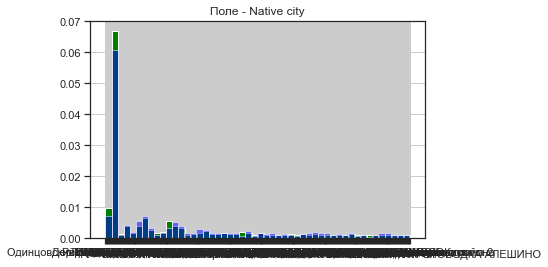

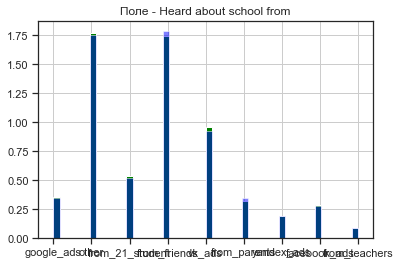

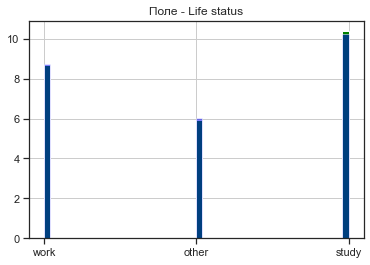

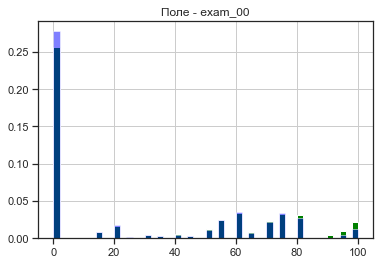

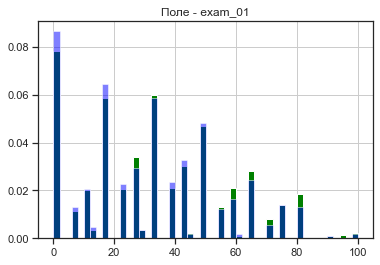

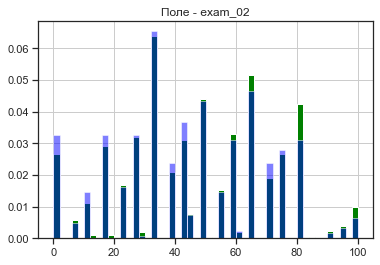

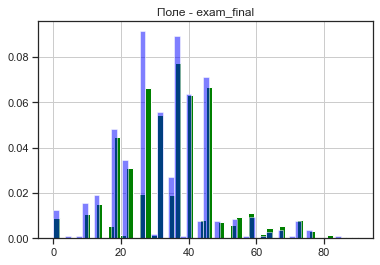

In [8]:
plot_hist_diff(data_loaded, data_drop, cols_with_na)

### 2. Заполнение значений для одного признака 

In [9]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [10]:
#Заполнение показателем центра распределения
all_data, filled_data, missed_data = impute_column(data_loaded, 'rush_02', 'mean')
all_data

array([0.        , 0.        , 7.94900222, ..., 0.        , 0.        ,
       0.        ])

In [11]:
data_loaded['rush_02']

0       0.0
1       0.0
2       NaN
3       0.0
4       0.0
       ... 
1055    0.0
1056    NaN
1057    0.0
1058    0.0
1059    0.0
Name: rush_02, Length: 1060, dtype: float64

In [12]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

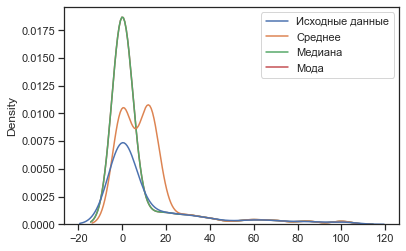

In [13]:
#Сравнение заполнения различными показателями распределения
research_impute_numeric_column(data_loaded, 'day_01')

In [14]:
#Заполнение наиболее распросттраненным значением категории
data_cat_cols = ['Native city', 'Heard about school from', 'Life status']
data_cat_new = data_loaded[data_cat_cols].copy()

In [15]:
data_cat_new

,Native city,Heard about school from,Life status
0,Пермь,google_ads,work
1,Волгоград,NaN,NaN
2,Новосибирск,other,work
3,Тула,NaN,NaN
4,Голицыно,other,other
...,...,...,...
1055,Тверь,vk_ads,study
1056,"Р-Н ВОСКРЕСЕНСКИЙ, НП СЛОБОДКА АЛЕШИНО",from_friends,study
1057,Москва,from_friends,study
1058,Москва,NaN,NaN


In [16]:
data_loaded.loc[data_loaded.loc[:, 'Native city'] == 'Новозыбков']

,id,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,...,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game,contract_status
992,726006708,1998-06-12,Новозыбков,female,3,5.608491,yandex_ads,study,20,0.0,...,0.0,0.0,60.0,54.0,59.0,36.0,NaN,9,7,1


In [17]:
NativeCity_cat_new, _, _ = impute_column(data_cat_new, 'Native city', 'most_frequent')
HeardAboutSchoolFrom_cat_new, _, _ = impute_column(data_cat_new, 'Heard about school from', 'most_frequent')
LifeStatus_cat_new, _, _ = impute_column(data_cat_new, 'Life status', 'most_frequent')

In [18]:
data_cat_new['Native city'] = NativeCity_cat_new
data_cat_new['Heard about school from'] = HeardAboutSchoolFrom_cat_new
data_cat_new['Life status'] = LifeStatus_cat_new

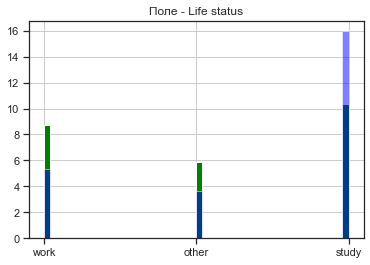

In [19]:
plot_hist_diff(data_loaded, data_cat_new, ['Life status'])

# Кодирование категориальных признаков

### 1. Label Encoding 

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
data = data_loaded.copy()
data['Heard about school from']

0         google_ads
1                NaN
2              other
3                NaN
4              other
            ...     
1055          vk_ads
1056    from_friends
1057    from_friends
1058             NaN
1059             NaN
Name: Heard about school from, Length: 1060, dtype: object

In [22]:
data['Heard about school from'] = data_cat_new['Heard about school from']
data['Heard about school from']

0         google_ads
1              other
2              other
3              other
4              other
            ...     
1055          vk_ads
1056    from_friends
1057    from_friends
1058           other
1059           other
Name: Heard about school from, Length: 1060, dtype: object

In [23]:
data_loaded['Heard about school from']

0         google_ads
1                NaN
2              other
3                NaN
4              other
            ...     
1055          vk_ads
1056    from_friends
1057    from_friends
1058             NaN
1059             NaN
Name: Heard about school from, Length: 1060, dtype: object

In [24]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(data['Heard about school from'])
cat_enc_le

array([5, 6, 6, ..., 2, 6, 6])

In [25]:
data['Heard about school from'].unique()

array(['google_ads', 'other', 'from_21_student', 'from_friends', 'vk_ads',
       'from_parents', 'yandex_ads', 'facebook_ads', 'from_teachers'],
      dtype=object)

In [26]:
np.unique(cat_enc_le)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [27]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])

array(['facebook_ads', 'from_21_student', 'from_friends', 'from_parents',
       'from_teachers', 'google_ads', 'other', 'vk_ads', 'yandex_ads'],
      dtype=object)

###  2. One-Hot Encoding

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(data[['Heard about school from']])
cat_enc_ohe

<1060x9 sparse matrix of type '<class 'numpy.float64'>'
	with 1060 stored elements in Compressed Sparse Row format>

In [30]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [31]:
# one-hot encoding с помощью pd.get_dummies()
pd.get_dummies(data[['Heard about school from']]).head()

,Heard about school from_facebook_ads,Heard about school from_from_21_student,Heard about school from_from_friends,Heard about school from_from_parents,Heard about school from_from_teachers,Heard about school from_google_ads,Heard about school from_other,Heard about school from_vk_ads,Heard about school from_yandex_ads
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0


In [32]:
# с добавлением отдельной колонки - признака пустых значений
pd.get_dummies(data_loaded[['Heard about school from']], dummy_na=True).head()

,Heard about school from_facebook_ads,Heard about school from_from_21_student,Heard about school from_from_friends,Heard about school from_from_parents,Heard about school from_from_teachers,Heard about school from_google_ads,Heard about school from_other,Heard about school from_vk_ads,Heard about school from_yandex_ads,Heard about school from_nan
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0


# Нормализация числовых признаков

In [33]:
import scipy.stats as stats

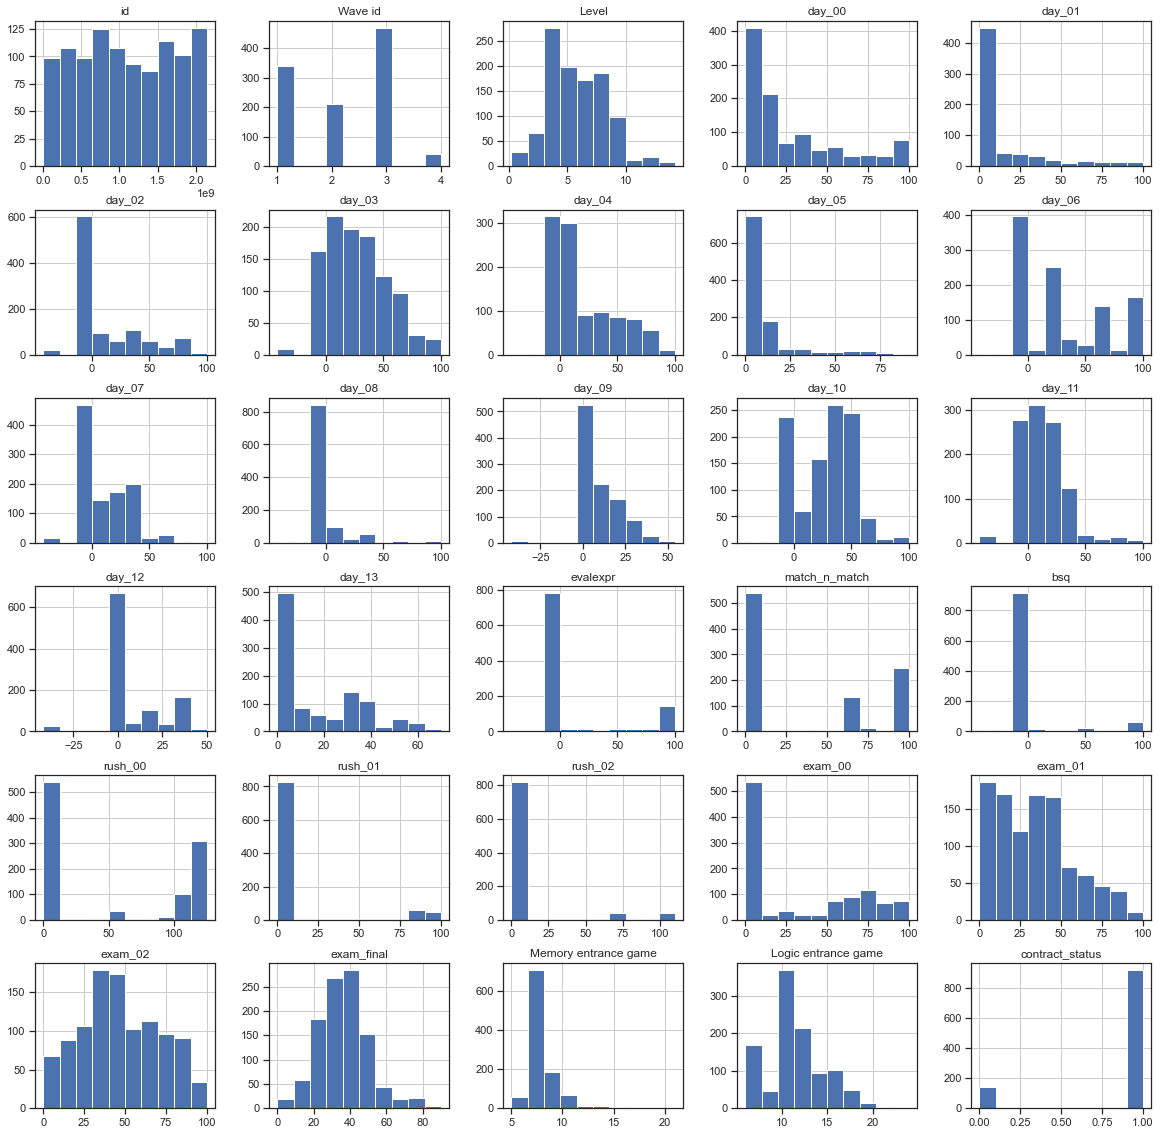

In [34]:
data.hist(figsize=(20,20))
plt.show()

In [35]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

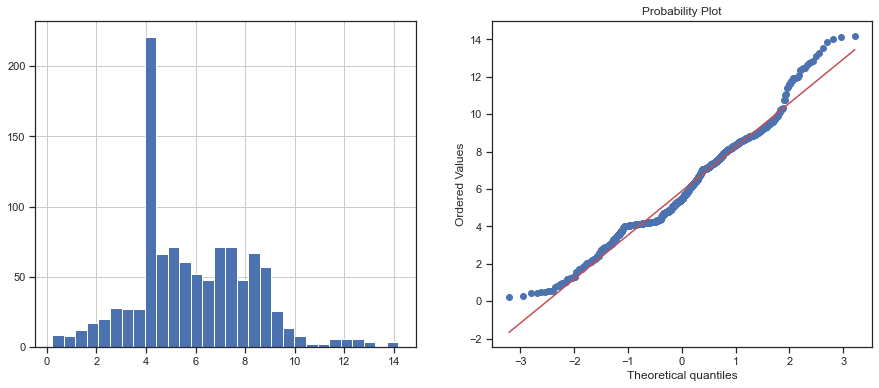

In [36]:
diagnostic_plots(data, 'Level')

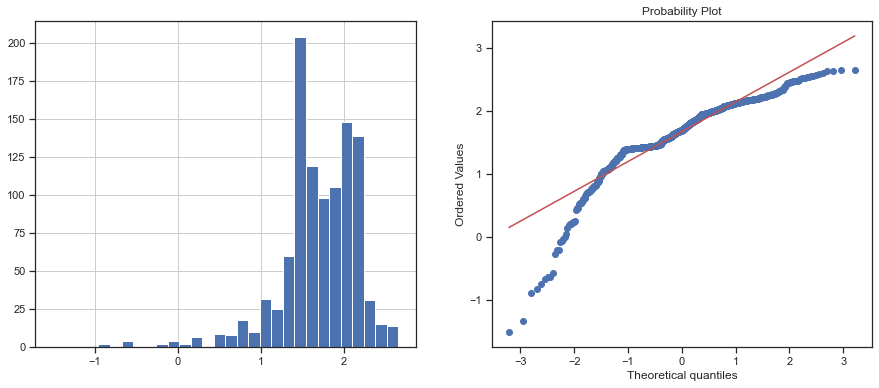

In [37]:
data['Level_log'] = np.log(data['Level'])
diagnostic_plots(data, 'Level_log')

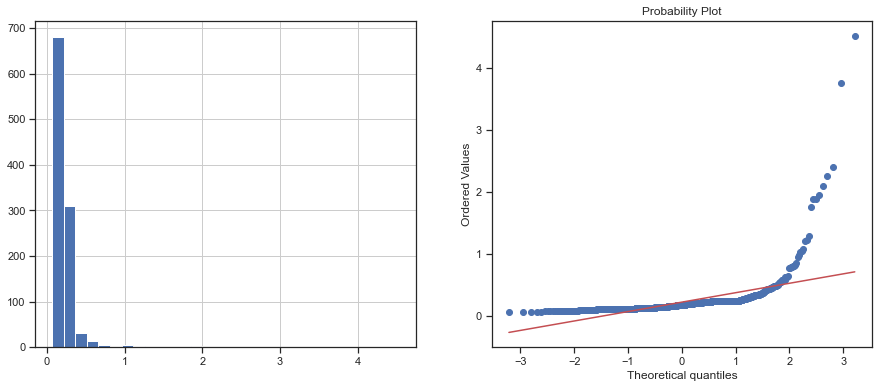

In [38]:
data['Level_reciprocal'] = 1 / (data['Level']) 
diagnostic_plots(data, 'Level_reciprocal')

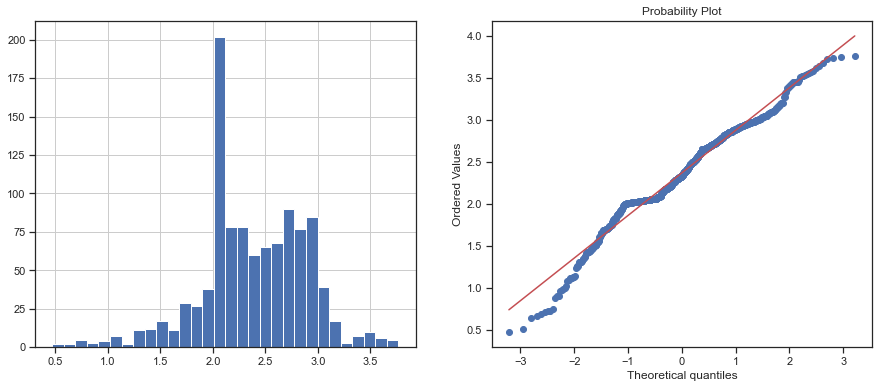

In [39]:
data['Level_sqr'] = data['Level']**(1/2) 
diagnostic_plots(data, 'Level_sqr')

Оптимальное значение λ = 0.7133505164876188


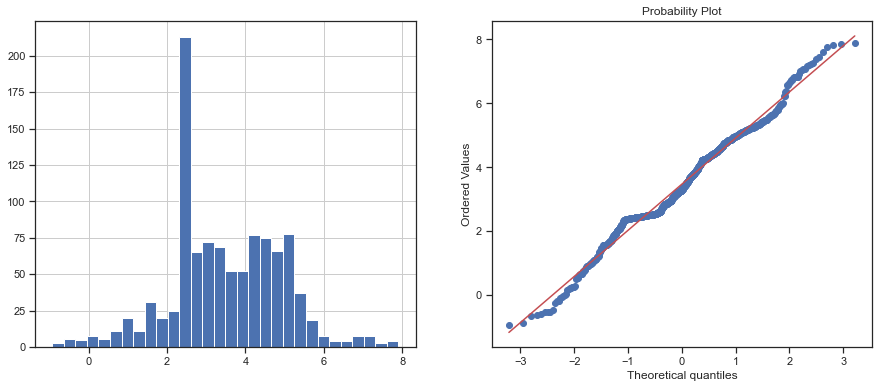

In [40]:
data['Level_boxcox'], param = stats.boxcox(data['Level']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Level_boxcox')

Оптимальное значение λ = 0.6346347163496497


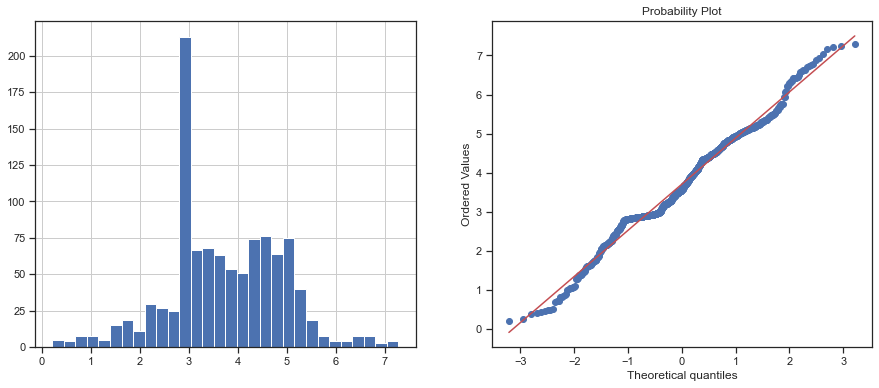

In [41]:
# Необходимо преобразовать данные к действительному типу
data['Level'] = data['Level'].astype('float')
data['Level_yeojohnson'], param = stats.yeojohnson(data['Level']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Level_yeojohnson')

# Масштабирование признаков

### На основе Z-оценки

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [43]:
cols_to_scale = ['Wave id', 'Level', 'day_00', 'day_01', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06', 
                 'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13', 'evalexpr', 'match_n_match',
                 'bsq', 'rush_00', 'rush_01', 'rush_02', 'exam_00', 'exam_01', 'exam_02', 'exam_final', 
                 'Memory entrance game', 'Logic entrance game', 'contract_status']
data_to_scale = data_loaded[cols_to_scale]
data_to_scale = data_to_scale.dropna()
data_to_scale.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,2.440367,5.853601,28.033639,15.599388,17.788991,29.529052,24.608563,10.226300,39.859327,15.565749,...,49.675841,11.058104,9.388379,34.296636,36.244648,50.856269,35.993884,8.204893,11.709480,0.871560
std,0.934327,2.178283,29.094443,26.074723,28.112637,26.077484,26.458319,17.239316,38.290203,18.670565,...,55.301506,29.070672,27.505029,35.796726,23.316996,23.380308,14.705492,1.522099,3.225379,0.335092
min,1.000000,0.265487,0.000000,0.000000,-42.000000,-42.000000,0.000000,0.000000,0.000000,-42.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,0.000000
25%,1.500000,4.245989,5.000000,0.000000,0.000000,10.000000,5.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,16.500000,32.000000,27.000000,7.000000,10.000000,1.000000
50%,3.000000,5.471698,10.000000,0.000000,0.000000,25.000000,10.000000,5.000000,20.000000,10.000000,...,10.000000,0.000000,0.000000,20.000000,32.000000,49.000000,36.000000,8.000000,11.000000,1.000000
75%,3.000000,7.375000,43.500000,25.000000,35.000000,50.000000,40.000000,10.000000,70.000000,30.000000,...,120.000000,0.000000,0.000000,70.000000,54.000000,70.000000,45.000000,9.000000,14.000000,1.000000
max,4.000000,14.184049,100.000000,100.000000,100.000000,100.000000,100.000000,83.000000,100.000000,100.000000,...,125.000000,100.000000,110.000000,100.000000,95.000000,100.000000,90.000000,18.000000,23.000000,1.000000


In [44]:
X_ALL = data_to_scale.drop('contract_status', axis=1)
X_ALL

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
3,1,8.146104,5,0.0,35.0,25.0,20.0,2.0,70.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6
12,3,3.551515,10,10.0,35.0,30.0,5.0,1.0,70.0,40.0,...,50.0,10.0,0.0,0.0,50.0,32.0,33.0,18.0,8,11
19,2,8.831169,62,0.0,0.0,57.0,5.0,3.0,100.0,30.0,...,0.0,120.0,0.0,0.0,0.0,54.0,80.0,40.0,8,10
22,2,6.766667,10,0.0,-42.0,50.0,10.0,79.0,100.0,20.0,...,100.0,0.0,0.0,0.0,80.0,70.0,80.0,45.0,9,14
24,1,12.393701,100,100.0,80.0,65.0,5.0,70.0,0.0,0.0,...,0.0,120.0,0.0,100.0,70.0,59.0,0.0,53.0,8,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,3,8.159091,10,40.0,35.0,15.0,85.0,5.0,100.0,40.0,...,100.0,120.0,0.0,0.0,95.0,75.0,75.0,40.0,8,9
1047,3,4.828877,20,62.0,80.0,50.0,40.0,10.0,100.0,0.0,...,0.0,120.0,0.0,0.0,75.0,59.0,70.0,0.0,7,7
1049,4,4.887701,30,0.0,50.0,15.0,40.0,10.0,70.0,40.0,...,0.0,0.0,0.0,0.0,60.0,32.0,59.0,18.0,8,8
1051,1,7.025735,5,30.0,35.0,65.0,30.0,48.0,70.0,0.0,...,0.0,10.0,0.0,0.0,0.0,48.0,48.0,36.0,9,12


In [45]:
# Функция восстановления датафрейма на основе масштабированных данных 
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res

In [46]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data_to_scale['contract_status'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((261, 28), (66, 28))

In [47]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
0,-1.543972,1.054049,-0.792898,-0.599174,0.613154,-0.173943,-0.174449,-0.477914,0.788370,-0.834983,...,-0.325965,-0.899650,-0.380970,-0.341856,-0.959563,-1.556813,-1.021921,-0.612538,0.523176,-1.772886
1,0.599887,-1.058455,-0.620781,-0.215073,0.613154,0.018087,-0.742247,-0.536010,0.788370,1.310710,...,1.509273,-0.718545,-0.380970,-0.341856,0.439354,-0.182320,-0.764902,-1.225492,-0.134818,-0.220305
2,-0.472042,1.369028,1.169241,-0.599174,-0.633745,1.055050,-0.742247,-0.419818,1.573061,0.774287,...,-0.325965,1.273599,-0.380970,-0.341856,-0.959563,0.762644,1.248418,0.272841,-0.134818,-0.530821
3,-0.472042,0.419810,-0.620781,-0.599174,-2.130025,0.786208,-0.552981,3.995466,1.573061,0.237864,...,3.344512,-0.899650,-0.380970,-0.341856,1.278704,1.449890,1.248418,0.613371,0.523176,0.711244
4,-1.543972,3.007012,2.477334,3.241835,2.216311,1.362298,-0.742247,3.472603,-1.042575,-0.834983,...,-0.325965,1.273599,-0.380970,3.299414,0.998920,0.977408,-2.178509,1.158219,-0.134818,2.574341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.599887,1.060020,-0.620781,0.937230,0.613154,-0.558003,2.286010,-0.303626,1.573061,1.310710,...,3.344512,1.273599,-0.380970,-0.341856,1.698379,1.664655,1.034235,0.272841,-0.134818,-0.841338
323,0.599887,-0.471148,-0.276546,1.782252,2.216311,0.786208,0.582615,-0.013147,1.573061,-0.834983,...,-0.325965,1.273599,-0.380970,-0.341856,1.138812,0.977408,0.820052,-2.451400,-0.792813,-1.462370
324,1.671817,-0.444102,0.067689,-0.599174,1.147540,-0.558003,0.582615,-0.013147,0.788370,1.310710,...,-0.325965,-0.899650,-0.380970,-0.341856,0.719137,-0.182320,0.348850,-1.225492,-0.134818,-1.151854
325,-1.543972,0.538925,-0.792898,0.553129,0.613154,1.362298,0.204083,2.194495,0.788370,-0.834983,...,-0.325965,-0.718545,-0.380970,-0.341856,-0.959563,0.504926,-0.122353,0.000417,0.523176,0.090211


In [48]:
# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

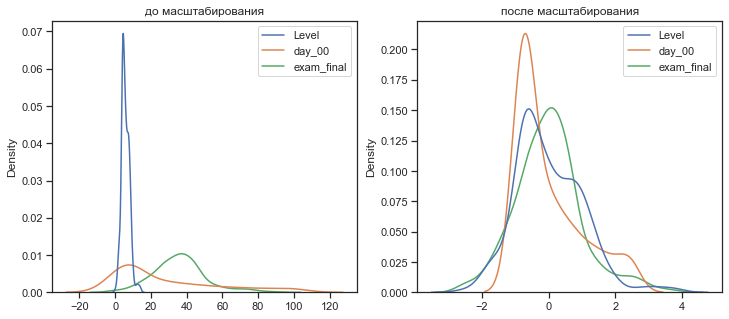

In [49]:
draw_kde(['Level', 'day_00', 'exam_final'], data_to_scale, data_cs11_scaled, 'до масштабирования', 'после масштабирования')

In [50]:
# Обучаем StandardScaler на обучающей выборке 
# и масштабируем обучающую и тестовую выборки
cs12 = StandardScaler()
cs12.fit(X_train)
data_cs12_scaled_train_temp = cs12.transform(X_train)
data_cs12_scaled_test_temp = cs12.transform(X_test)
# формируем DataFrame на основе массива
data_cs12_scaled_train = arr_to_df(data_cs12_scaled_train_temp)
data_cs12_scaled_test = arr_to_df(data_cs12_scaled_test_temp)

In [51]:
data_cs12_scaled_train.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,...,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
mean,-1.769551e-16,8.619116e-17,-5.529846e-17,-2.599028e-16,1.701491e-18,1.088954e-16,-6.508204e-17,-3.551863e-17,-3.147759e-17,1.076193e-16,...,1.816342e-16,4.934325e-17,1.267611e-16,1.595148e-16,-1.429253e-16,-2.075819e-16,1.227201e-16,-1.593021e-16,-2.518207e-16,-2.501192e-16
std,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,...,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00
min,-1.468038e+00,-2.255201e+00,-9.748218e-01,-6.126409e-01,-2.166553e+00,-2.761168e+00,-9.183685e-01,-5.628501e-01,-1.029487e+00,-3.044573e+00,...,-1.920788e+00,-9.368121e-01,-3.574032e-01,-3.559018e-01,-9.154562e-01,-1.523374e+00,-2.224495e+00,-2.374555e+00,-1.436548e+00,-1.753620e+00
25%,-1.468038e+00,-7.784233e-01,-8.073024e-01,-6.126409e-01,-6.477351e-01,-7.630570e-01,-7.302846e-01,-5.052633e-01,-1.029487e+00,-8.194506e-01,...,-3.036084e-01,-9.368121e-01,-3.574032e-01,-3.559018e-01,-9.154562e-01,-8.546461e-01,-8.429526e-01,-6.056873e-01,-8.010583e-01,-5.331004e-01
50%,6.547204e-01,-1.217576e-01,-6.397829e-01,-6.126409e-01,-6.477351e-01,-1.866788e-01,-5.422006e-01,-3.900897e-01,-5.173924e-01,-2.896596e-01,...,-3.036084e-01,-7.558827e-01,-3.574032e-01,-3.559018e-01,-4.945506e-01,-1.859180e-01,-1.090082e-01,-1.606464e-02,-1.655683e-01,-2.279706e-01
75%,6.547204e-01,6.697914e-01,7.003723e-01,3.520024e-01,6.179462e-01,7.739515e-01,9.624710e-01,1.301770e-02,7.628448e-01,7.699222e-01,...,-3.036084e-01,1.234340e+00,-3.574032e-01,-3.559018e-01,1.048770e+00,7.335832e-01,7.976290e-01,5.735580e-01,4.699217e-01,6.874189e-01
max,1.716100e+00,3.788985e+00,2.375566e+00,3.245932e+00,2.968497e+00,2.695212e+00,2.843310e+00,4.216853e+00,1.530987e+00,4.478459e+00,...,3.546819e+00,1.324805e+00,3.252590e+00,3.471042e+00,1.890581e+00,2.447199e+00,2.092825e+00,3.521671e+00,6.189332e+00,3.433587e+00


In [52]:
data_cs12_scaled_test.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.300927,-0.216562,-0.176313,-0.053148,-0.022017,-0.062670,0.036300,0.129064,-0.044093,0.025807,...,0.189946,-0.188422,0.207069,-0.145051,0.232468,-0.042167,-0.143023,-0.081578,-0.175197,-0.056913
std,0.918395,0.991960,0.851463,1.029178,1.080595,1.008578,0.975535,0.956090,0.896579,0.944041,...,1.221276,0.988389,1.213890,0.748361,1.000567,0.863992,1.038355,0.796428,0.807635,0.916373
min,-1.468038,-2.614704,-0.974822,-0.612641,-2.166553,-2.761168,-0.918369,-0.562850,-1.029487,-3.044573,...,-0.303608,-0.936812,-0.357403,-0.355902,-0.915456,-1.523374,-2.224495,-2.374555,-1.436548,-1.753620
25%,-0.141314,-0.800566,-0.807302,-0.612641,-0.647735,-0.907152,-0.871348,-0.505263,-0.901464,-0.819451,...,-0.303608,-0.936812,-0.357403,-0.355902,-0.915456,-0.603873,-0.842953,-0.605687,-0.801058,-0.533100
50%,0.654720,-0.489334,-0.639783,-0.612641,-0.647735,-0.186679,-0.260075,-0.274916,-0.517392,-0.024764,...,-0.303608,-0.936812,-0.357403,-0.355902,0.627864,-0.185918,-0.152181,-0.016065,-0.165568,-0.227971
75%,0.654720,0.402256,0.030295,0.159074,0.572743,0.773951,0.586303,0.099398,0.762845,0.769922,...,-0.303608,1.234340,-0.357403,-0.355902,1.153996,0.482810,0.538590,0.573558,-0.165568,0.382289
max,1.716100,2.965277,2.375566,3.245932,2.968497,2.695212,2.279059,3.468224,1.530987,2.359295,...,3.546819,1.234340,3.252590,3.123138,1.890581,1.820266,2.092825,1.425235,3.011882,2.518198


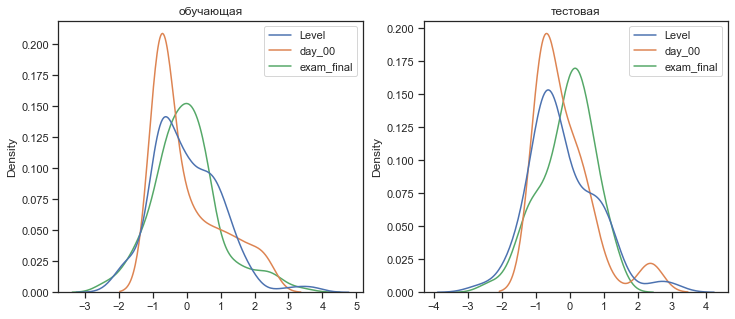

In [53]:
# распределения для обучающей и тестовой выборки немного отличаются
draw_kde(['Level', 'day_00', 'exam_final'], data_cs12_scaled_train, data_cs12_scaled_test, 'обучающая', 'тестовая')

### Масштабирование "Mean Normalisation"

In [54]:
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = X_train.mean(axis=0)
        maxs = X_train.max(axis=0)
        mins = X_train.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [55]:
sc21 = MeanNormalisation()
data_cs21_scaled = sc21.fit_transform(X_ALL)
data_cs21_scaled.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,0.019075,-0.007232,-0.010621,-0.002780,-0.000865,-0.002318,0.001948,0.005450,-0.003476,0.000692,...,0.007012,-0.016815,0.011577,-0.007650,0.016721,-0.002143,-0.006686,-0.002793,-0.004637,-0.002214
std,0.311442,0.165811,0.290944,0.260747,0.197976,0.183644,0.264583,0.207703,0.382902,0.131483,...,0.192156,0.442412,0.290707,0.250046,0.357967,0.245442,0.233803,0.163394,0.126842,0.189728
min,-0.461047,-0.432598,-0.290958,-0.158774,-0.421915,-0.506044,-0.244138,-0.117758,-0.402069,-0.404700,...,-0.351303,-0.414222,-0.099004,-0.092999,-0.326245,-0.383666,-0.515249,-0.402725,-0.188378,-0.338066
25%,-0.294381,-0.129603,-0.240958,-0.158774,-0.126140,-0.139847,-0.194138,-0.105710,-0.402069,-0.108926,...,-0.055529,-0.414222,-0.099004,-0.092999,-0.326245,-0.209982,-0.195249,-0.102725,-0.105045,-0.102772
50%,0.205619,-0.036302,-0.190958,-0.158774,-0.126140,-0.034213,-0.144138,-0.057517,-0.202069,-0.038503,...,-0.055529,-0.334222,-0.099004,-0.092999,-0.126245,-0.046824,-0.025249,-0.002725,-0.021711,-0.043949
75%,0.205619,0.108577,0.144042,0.091226,0.120339,0.141843,0.155862,0.002724,0.297931,0.102342,...,-0.055529,0.545778,-0.099004,-0.092999,0.373755,0.184755,0.184751,0.097275,0.061622,0.132522
max,0.538953,0.626881,0.709042,0.841226,0.578085,0.493956,0.755862,0.882242,0.597931,0.595300,...,0.648697,0.585778,0.900996,0.907001,0.673755,0.616334,0.484751,0.597275,0.811622,0.661934


In [56]:
cs22 = MeanNormalisation()
cs22.fit(X_train)
data_cs22_scaled_train = cs22.transform(X_train)
data_cs22_scaled_test = cs22.transform(X_test)

In [57]:
data_cs22_scaled_train.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,...,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
mean,-4.540855e-17,2.849865e-16,-1.254850e-17,4.572758e-18,6.593278e-18,1.637685e-17,-1.669588e-17,-8.188427e-18,2.041789e-17,1.648320e-18,...,4.498317e-17,5.572384e-17,-2.807461e-17,8.518090e-17,-4.657832e-17,-3.498691e-17,2.355502e-17,-2.988244e-17,-3.312591e-17,-3.339177e-17
std,3.146602e-01,1.657661e-01,2.990463e-01,2.596611e-01,1.951142e-01,1.836238e-01,2.663495e-01,2.096200e-01,3.913030e-01,1.331805e-01,...,1.832467e-01,4.430110e-01,2.775410e-01,2.618071e-01,3.570591e-01,2.523367e-01,2.320702e-01,1.699258e-01,1.313843e-01,1.931523e-01
min,-4.610473e-01,-3.731191e-01,-2.909579e-01,-1.587739e-01,-4.219146e-01,-5.060439e-01,-2.441379e-01,-1.177584e-01,-4.020690e-01,-4.047002e-01,...,-3.513032e-01,-4.142222e-01,-9.900383e-02,-9.299896e-02,-3.262452e-01,-3.836661e-01,-5.152490e-01,-4.027246e-01,-1.883780e-01,-3.380663e-01
25%,-4.610473e-01,-1.287888e-01,-2.409579e-01,-1.587739e-01,-1.261400e-01,-1.398467e-01,-1.941379e-01,-1.057102e-01,-4.020690e-01,-1.089256e-01,...,-5.552857e-02,-4.142222e-01,-9.900383e-02,-9.299896e-02,-3.262452e-01,-2.152450e-01,-1.952490e-01,-1.027246e-01,-1.050447e-01,-1.027721e-01
50%,2.056194e-01,-2.014458e-02,-1.909579e-01,-1.587739e-01,-1.261400e-01,-3.421294e-02,-1.441379e-01,-8.161381e-02,-2.020690e-01,-3.850305e-02,...,-5.552857e-02,-3.342222e-01,-9.900383e-02,-9.299896e-02,-1.762452e-01,-4.682396e-02,-2.524904e-02,-2.724564e-03,-2.171137e-02,-4.394861e-02
75%,2.056194e-01,1.108158e-01,2.090421e-01,9.122605e-02,1.203389e-01,1.418434e-01,2.558621e-01,2.723538e-03,2.979310e-01,1.023420e-01,...,-5.552857e-02,5.457778e-01,-9.900383e-02,-9.299896e-02,3.737548e-01,1.847550e-01,1.847510e-01,9.727544e-02,6.162197e-02,1.325220e-01
max,5.389527e-01,6.268809e-01,7.090421e-01,8.412261e-01,5.780854e-01,4.939561e-01,7.558621e-01,8.822416e-01,5.979310e-01,5.952998e-01,...,6.486968e-01,5.857778e-01,9.009962e-01,9.070010e-01,6.737548e-01,6.163339e-01,4.847510e-01,5.972754e-01,8.116220e-01,6.619337e-01


In [58]:
data_cs22_scaled_test.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.094508,-0.035830,-0.052625,-0.013774,-0.004288,-0.011486,0.009650,0.027002,-0.017220,0.003430,...,0.034740,-0.083313,0.057360,-0.037903,0.082846,-0.010620,-0.033128,-0.013836,-0.022974,-0.010972
std,0.288428,0.164118,0.254139,0.266725,0.210435,0.184844,0.259335,0.200031,0.350161,0.125487,...,0.223366,0.437027,0.336258,0.195550,0.356577,0.217599,0.240509,0.135074,0.105907,0.176660
min,-0.461047,-0.432598,-0.290958,-0.158774,-0.421915,-0.506044,-0.244138,-0.117758,-0.402069,-0.404700,...,-0.055529,-0.414222,-0.099004,-0.092999,-0.326245,-0.383666,-0.515249,-0.402725,-0.188378,-0.338066
25%,-0.044381,-0.132452,-0.240958,-0.158774,-0.126140,-0.166255,-0.231638,-0.105710,-0.352069,-0.108926,...,-0.055529,-0.414222,-0.099004,-0.092999,-0.326245,-0.152087,-0.195249,-0.102725,-0.105045,-0.102772
50%,0.205619,-0.080959,-0.190958,-0.158774,-0.126140,-0.034213,-0.069138,-0.057517,-0.202069,-0.003292,...,-0.055529,-0.414222,-0.099004,-0.092999,0.223755,-0.046824,-0.035249,-0.002725,-0.021711,-0.043949
75%,0.205619,0.066552,0.009042,0.041226,0.111536,0.141843,0.155862,0.020796,0.297931,0.102342,...,-0.055529,0.545778,-0.099004,-0.092999,0.411255,0.121597,0.124751,0.097275,-0.021711,0.073698
max,0.538953,0.490600,0.709042,0.841226,0.578085,0.493956,0.605862,0.725615,0.597931,0.313610,...,0.648697,0.545778,0.900996,0.816092,0.673755,0.458439,0.484751,0.241720,0.394955,0.485463


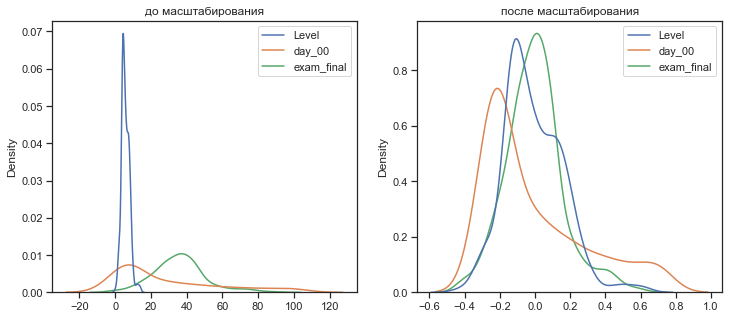

In [59]:
draw_kde(['Level', 'day_00', 'exam_final'], data_to_scale, data_cs21_scaled, 'до масштабирования', 'после масштабирования')

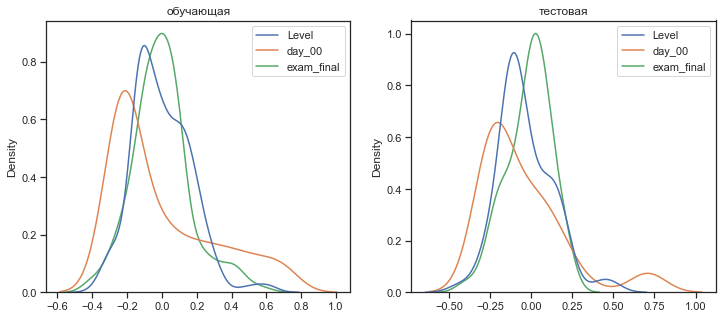

In [60]:
draw_kde(['Level', 'day_00', 'exam_final'], data_cs22_scaled_train, data_cs22_scaled_test, 'обучающая', 'тестовая')

### Min-Max Масштабирование

In [61]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs31 = MinMaxScaler()
data_cs31_scaled_temp = cs31.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs31_scaled = arr_to_df(data_cs31_scaled_temp)
data_cs31_scaled.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,0.480122,0.401486,0.280336,0.155994,0.421049,0.503726,0.246086,0.123208,0.398593,0.405393,...,0.358315,0.397407,0.110581,0.085349,0.342966,0.381523,0.508563,0.399932,0.183741,0.335852
std,0.311442,0.156502,0.290944,0.260747,0.197976,0.183644,0.264583,0.207703,0.382902,0.131483,...,0.192156,0.442412,0.290707,0.250046,0.357967,0.245442,0.233803,0.163394,0.126842,0.189728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.285985,0.050000,0.000000,0.295775,0.366197,0.050000,0.012048,0.000000,0.295775,...,0.295775,0.000000,0.000000,0.000000,0.000000,0.173684,0.320000,0.300000,0.083333,0.235294
50%,0.666667,0.374048,0.100000,0.000000,0.295775,0.471831,0.100000,0.060241,0.200000,0.366197,...,0.295775,0.080000,0.000000,0.000000,0.200000,0.336842,0.490000,0.400000,0.166667,0.294118
75%,0.666667,0.510794,0.435000,0.250000,0.542254,0.647887,0.400000,0.120482,0.700000,0.507042,...,0.295775,0.960000,0.000000,0.000000,0.700000,0.568421,0.700000,0.500000,0.250000,0.470588
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
cs32 = MinMaxScaler()
cs32.fit(X_train)
data_cs32_scaled_train_temp = cs32.transform(X_train)
data_cs32_scaled_test_temp = cs32.transform(X_test)
# формируем DataFrame на основе массива
data_cs32_scaled_train = arr_to_df(data_cs32_scaled_train_temp)
data_cs32_scaled_test = arr_to_df(data_cs32_scaled_test_temp)

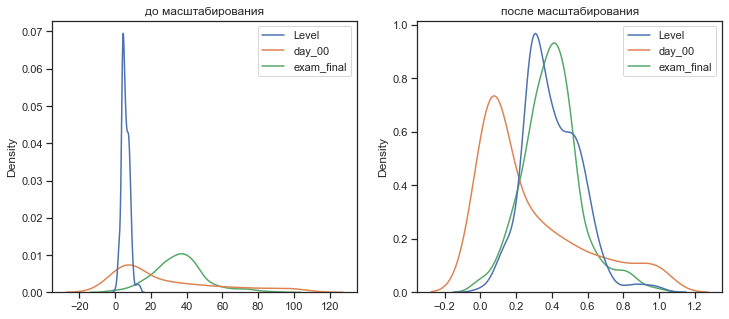

In [63]:
draw_kde(['Level', 'day_00', 'exam_final'], data_to_scale, data_cs31_scaled, 'до масштабирования', 'после масштабирования')

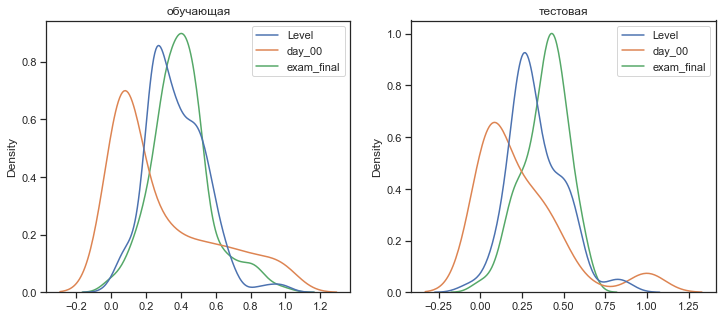

In [64]:
draw_kde(['Level', 'day_00', 'exam_final'], data_cs32_scaled_train, data_cs32_scaled_test, 'обучающая', 'тестовая')

### Масштабирование по медиане

In [65]:
cs41 = RobustScaler()
data_cs41_scaled_temp = cs41.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs41_scaled = arr_to_df(data_cs41_scaled_temp)
data_cs41_scaled.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,-0.373089,0.122052,0.468406,0.623976,0.508257,0.113226,0.417388,0.580700,0.283705,0.185525,...,8.880734,0.330632,11.058104,9.388379,0.204238,0.113191,0.048849,-0.000340,0.102446,0.177370
std,0.622885,0.696157,0.755700,1.042989,0.803218,0.651937,0.755952,1.915480,0.547003,0.622352,...,27.286165,0.460846,29.070672,27.505029,0.511382,0.621787,0.615271,0.816972,0.761050,0.806345
min,-1.333333,-1.663852,-0.259740,0.000000,-1.200000,-1.675000,-0.285714,-0.555556,-0.285714,-1.733333,...,-42.000000,-0.083333,0.000000,0.000000,-0.285714,-0.853333,-1.289474,-2.000000,-1.000000,-1.250000
25%,-1.000000,-0.391724,-0.129870,0.000000,0.000000,-0.375000,-0.142857,-0.444444,-0.285714,-0.333333,...,0.000000,-0.083333,0.000000,0.000000,-0.285714,-0.413333,-0.447368,-0.500000,-0.500000,-0.250000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.608276,0.870130,1.000000,1.000000,0.625000,0.857143,0.555556,0.714286,0.666667,...,0.000000,0.916667,0.000000,0.000000,0.714286,0.586667,0.552632,0.500000,0.500000,0.750000
max,0.666667,2.784379,2.337662,4.000000,2.857143,1.875000,2.571429,8.666667,1.142857,3.000000,...,100.000000,0.958333,100.000000,110.000000,1.142857,1.680000,1.342105,3.000000,5.000000,3.000000


In [66]:
cs42 = RobustScaler()
cs42.fit(X_train)
data_cs42_scaled_train_temp = cs42.transform(X_train)
data_cs42_scaled_test_temp = cs42.transform(X_test)
# формируем DataFrame на основе массива
data_cs42_scaled_train = arr_to_df(data_cs42_scaled_train_temp)
data_cs42_scaled_test = arr_to_df(data_cs42_scaled_test_temp)

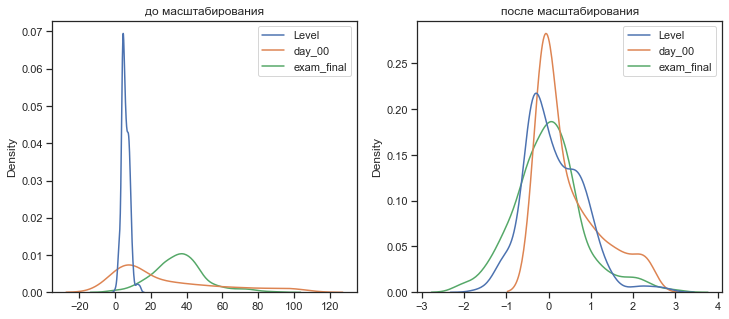

In [67]:
draw_kde(['Level', 'day_00', 'exam_final'], data_to_scale, data_cs41_scaled, 'до масштабирования', 'после масштабирования')

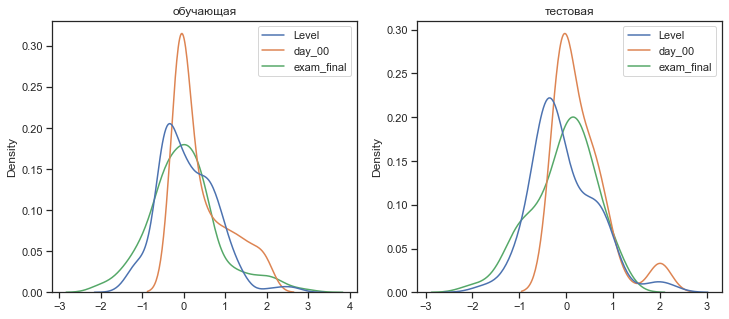

In [68]:
draw_kde(['Level', 'day_00', 'exam_final'], data_cs42_scaled_train, data_cs42_scaled_test, 'обучающая', 'тестовая')

### Масштабирование по максимальному значению

In [69]:
cs51 = MaxAbsScaler()
data_cs51_scaled_temp = cs51.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs51_scaled = arr_to_df(data_cs51_scaled_temp)
data_cs51_scaled.describe()

,Wave id,Level,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,0.610092,0.412689,0.280336,0.155994,0.177890,0.295291,0.246086,0.123208,0.398593,0.155657,...,0.088807,0.397407,0.110581,0.085349,0.342966,0.381523,0.508563,0.399932,0.455827,0.509108
std,0.233582,0.153573,0.290944,0.260747,0.281126,0.260775,0.264583,0.207703,0.382902,0.186706,...,0.272862,0.442412,0.290707,0.250046,0.357967,0.245442,0.233803,0.163394,0.084561,0.140234
min,0.250000,0.018717,0.000000,0.000000,-0.420000,-0.420000,0.000000,0.000000,0.000000,-0.420000,...,-0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.260870
25%,0.375000,0.299350,0.050000,0.000000,0.000000,0.100000,0.050000,0.012048,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.173684,0.320000,0.300000,0.388889,0.434783
50%,0.750000,0.385764,0.100000,0.000000,0.000000,0.250000,0.100000,0.060241,0.200000,0.100000,...,0.000000,0.080000,0.000000,0.000000,0.200000,0.336842,0.490000,0.400000,0.444444,0.478261
75%,0.750000,0.519950,0.435000,0.250000,0.350000,0.500000,0.400000,0.120482,0.700000,0.300000,...,0.000000,0.960000,0.000000,0.000000,0.700000,0.568421,0.700000,0.500000,0.500000,0.608696
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
cs52_mas = MaxAbsScaler()
cs52_mean = StandardScaler(with_mean=True, with_std=False)

cs52_mas.fit(X_train)
cs52_mean.fit(X_train)

data_cs52_scaled_train_temp = cs52_mas.transform(cs52_mean.transform(X_train))
data_cs52_scaled_test_temp = cs52_mas.transform(cs52_mean.transform(X_test))
# формируем DataFrame на основе массива
data_cs52_scaled_train = arr_to_df(data_cs52_scaled_train_temp)
data_cs52_scaled_test = arr_to_df(data_cs52_scaled_test_temp)

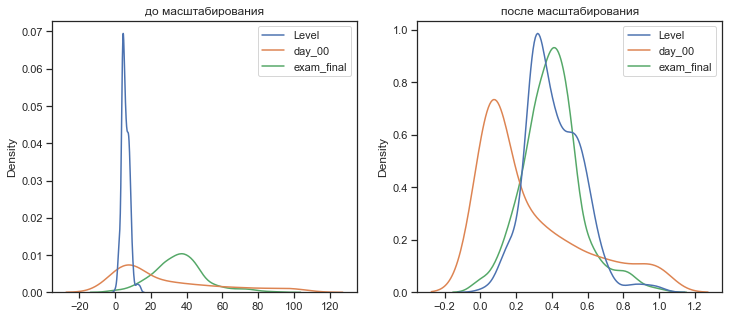

In [71]:
draw_kde(['Level', 'day_00', 'exam_final'], data_to_scale, data_cs51_scaled, 'до масштабирования', 'после масштабирования')

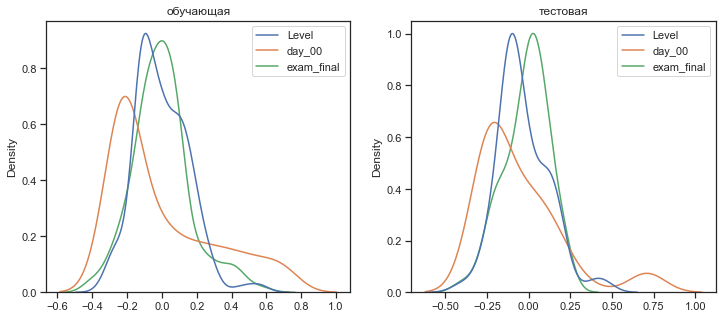

In [72]:
draw_kde(['Level', 'day_00', 'exam_final'], data_cs52_scaled_train, data_cs52_scaled_test, 'обучающая', 'тестовая')

# Обучение моделей с различными вариантами масштабирования признаков 

In [73]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [75]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [76]:
X_data_dict = {'Original': (X_train_df, X_test_df),
               'StandardScaler': (data_cs12_scaled_train, data_cs12_scaled_test), 
               'MeanNormalisation': (data_cs22_scaled_train, data_cs22_scaled_test),
               'MinMaxScaler': (data_cs32_scaled_train, data_cs32_scaled_test), 
               'RobustScaler': (data_cs42_scaled_train, data_cs42_scaled_test),
               'MaxAbsScaler': (data_cs52_scaled_train, data_cs52_scaled_test)}

In [77]:
def test_models(clas_models_dict, X_data_dict, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        
        for data_name, data_tuple in X_data_dict.items():

            X_train, X_test = data_tuple
              
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, data_name, mse)
            
    return logger

In [78]:
%%time
logger = test_models(clas_models_dict, X_data_dict, y_train, y_test)

Wall time: 1.12 s


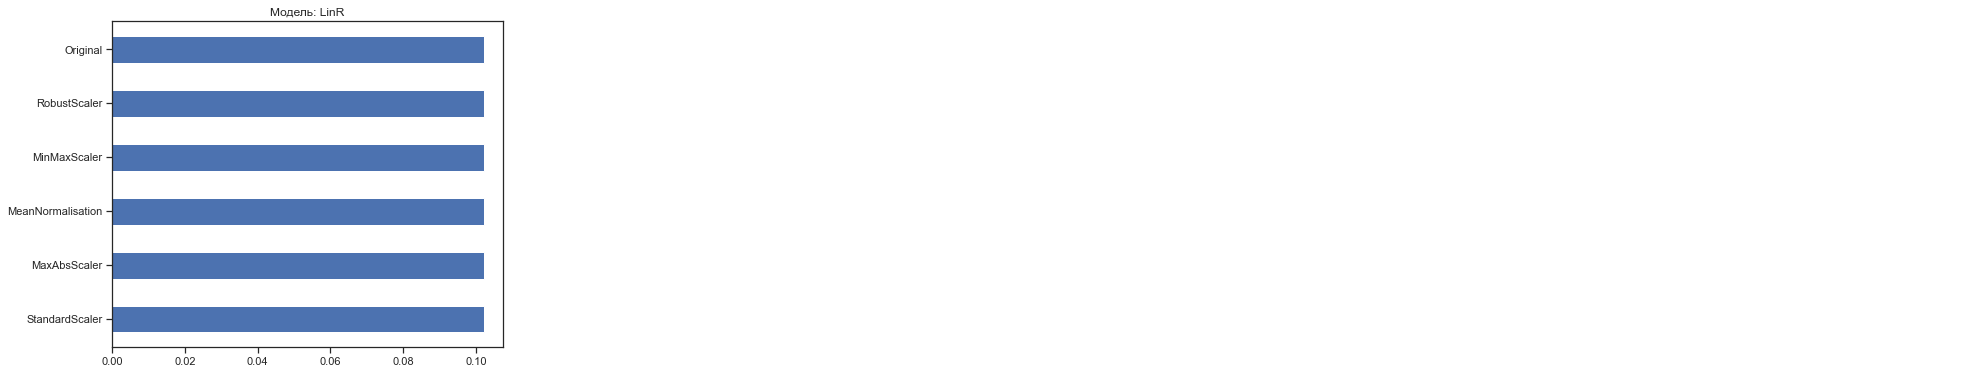

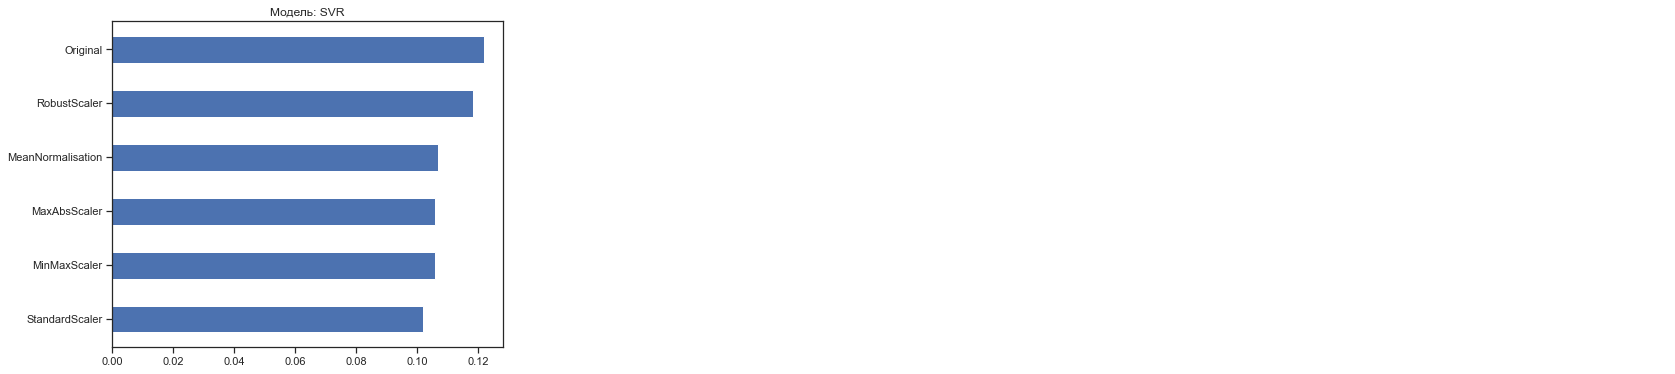

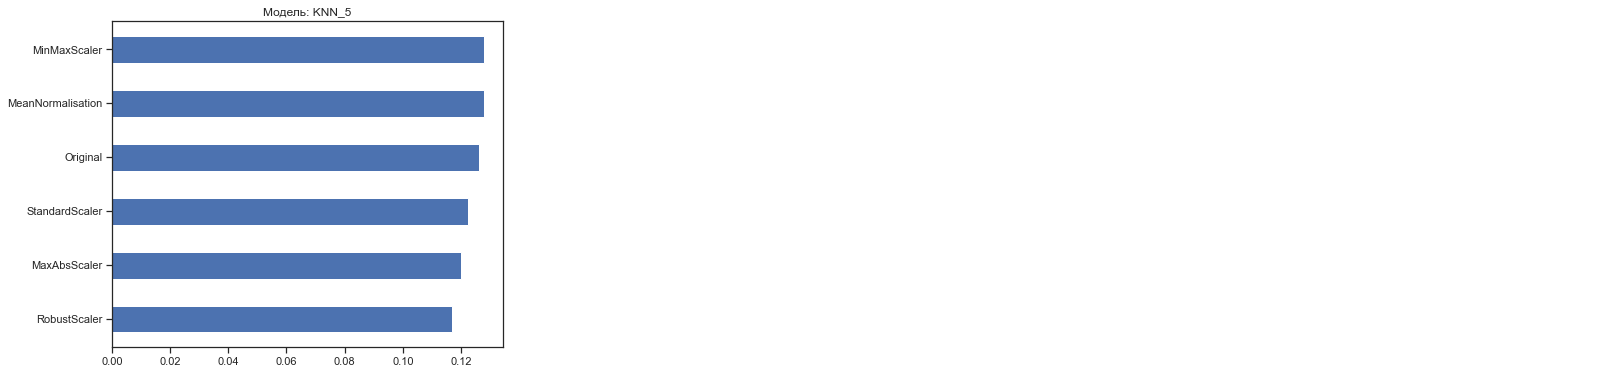

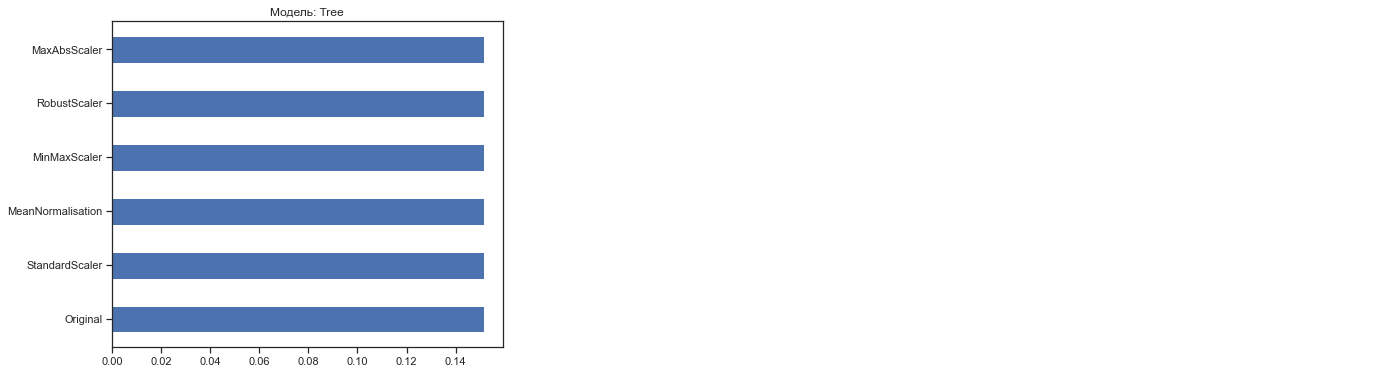

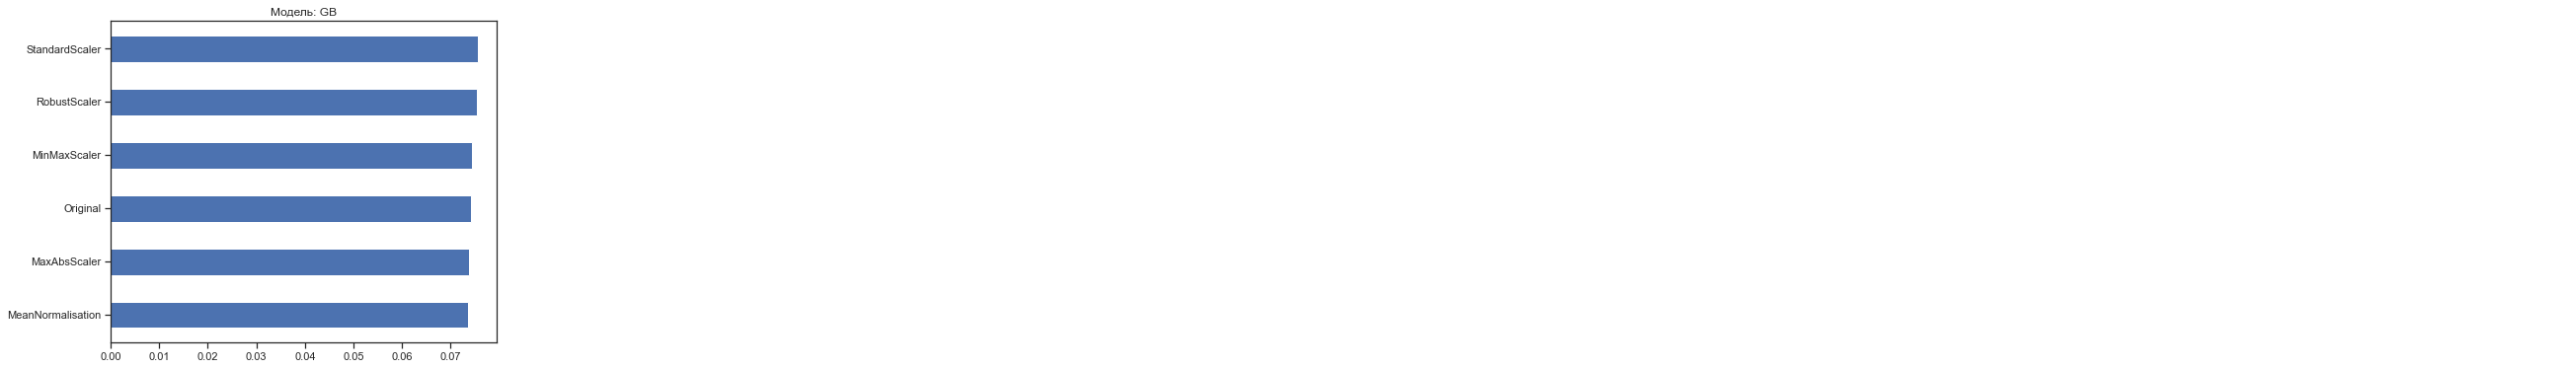

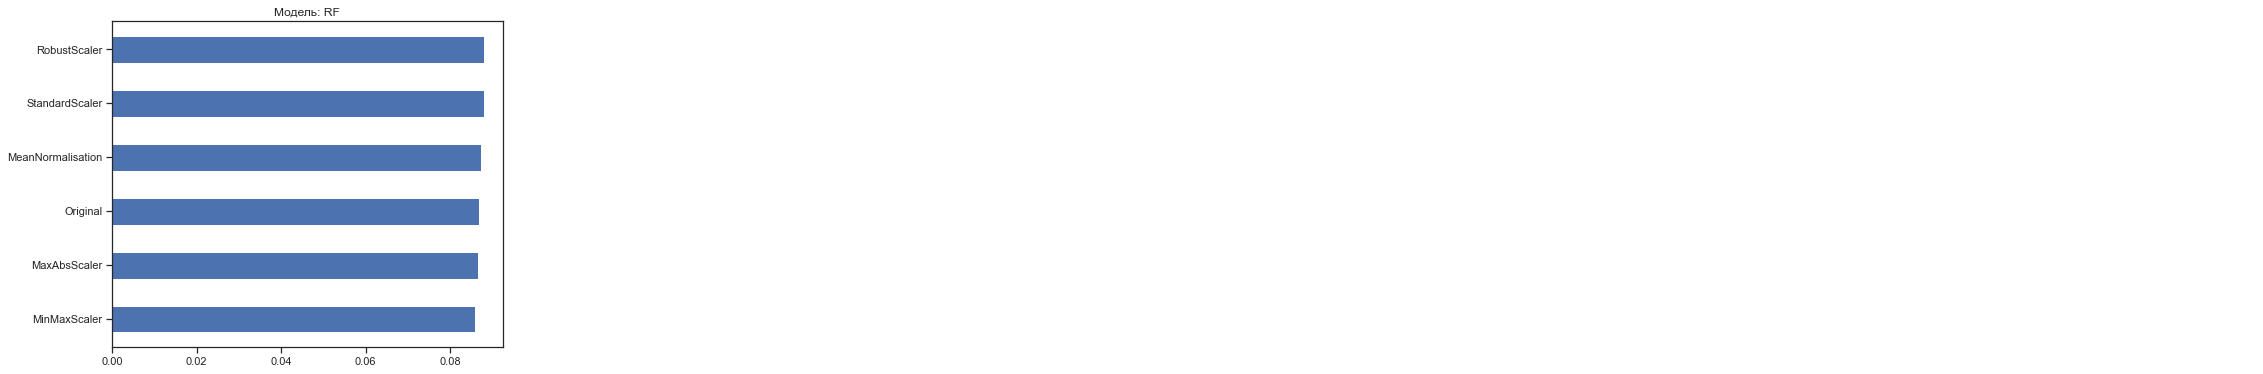

In [79]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

# Обработка выбросов

In [80]:
x_col_list = ['Level', 'exam_final', 'Memory entrance game']

In [81]:
data_to_scale.shape

(327, 29)

In [82]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

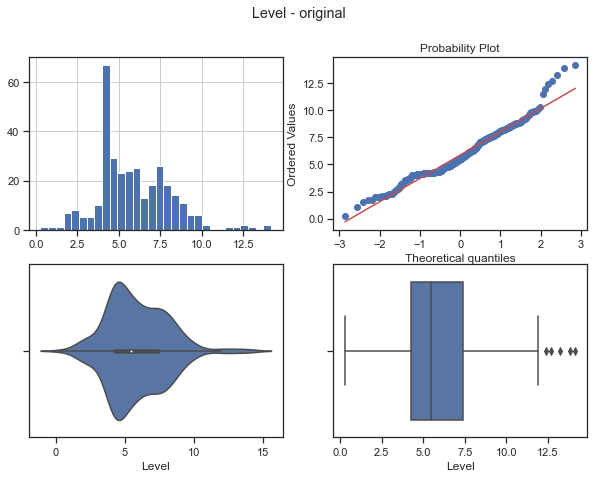

In [83]:
diagnostic_plots(data_to_scale, 'Level', 'Level - original')

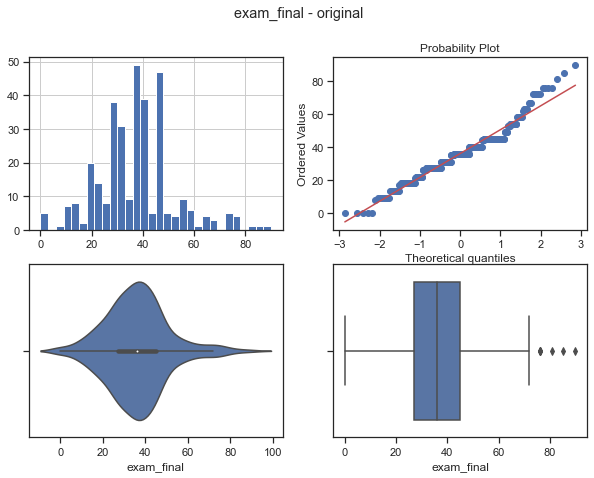

In [84]:
diagnostic_plots(data_to_scale, 'exam_final', 'exam_final - original')

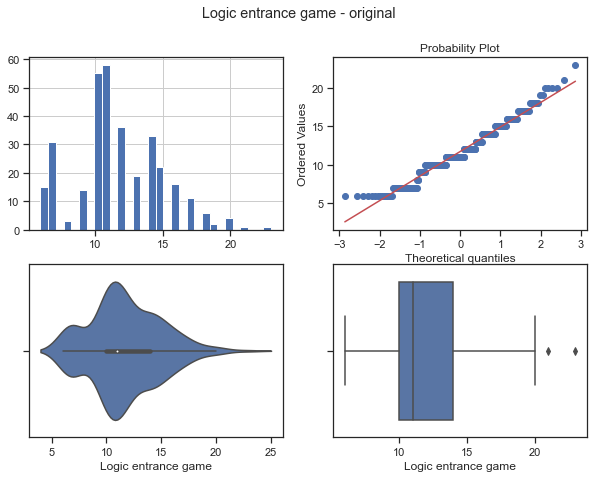

In [85]:
diagnostic_plots(data_to_scale, 'Logic entrance game', 'Logic entrance game - original')

### Обнаружение выбросов 

In [86]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [87]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary 

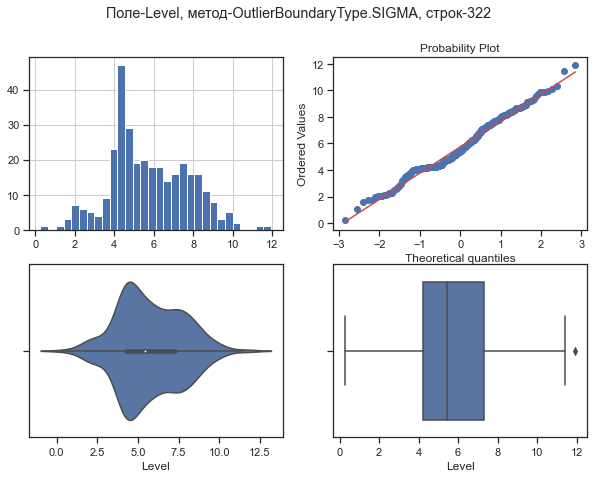

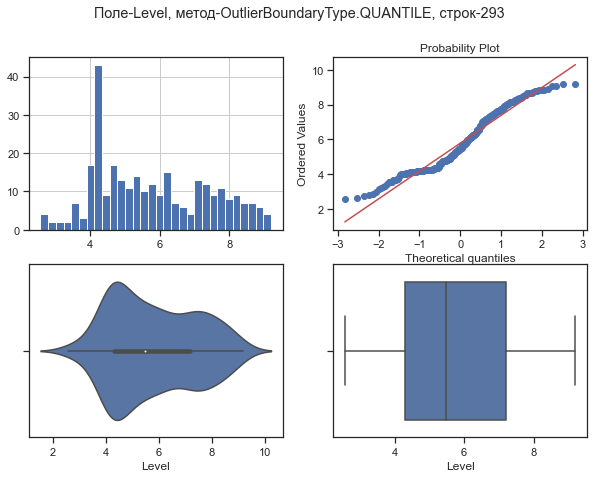

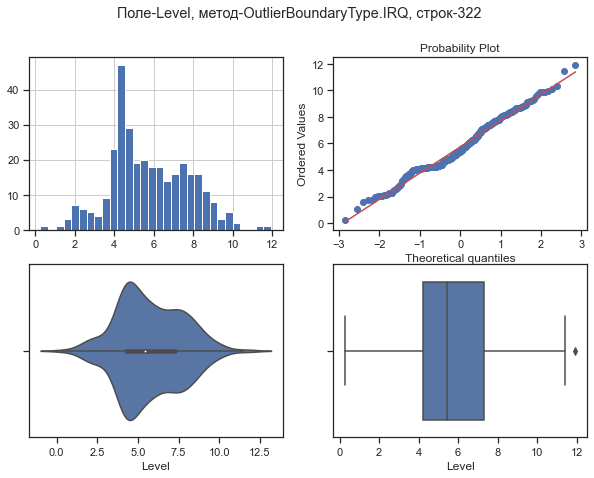

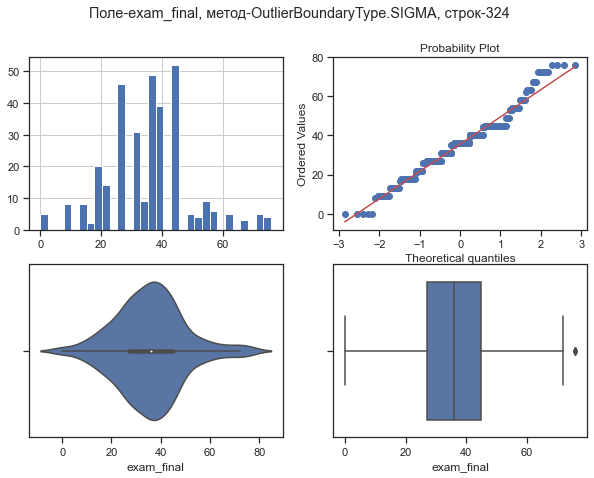

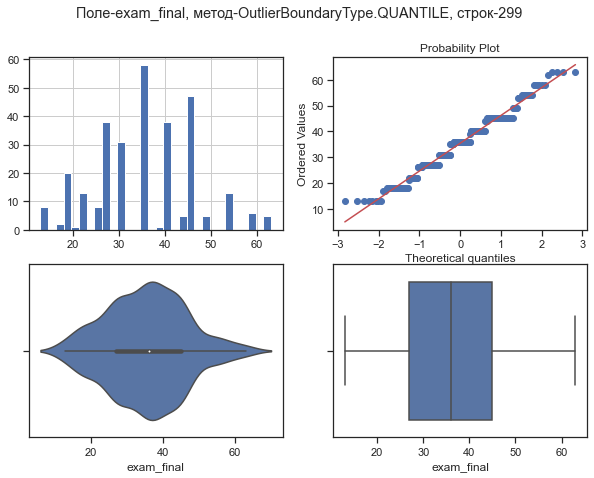

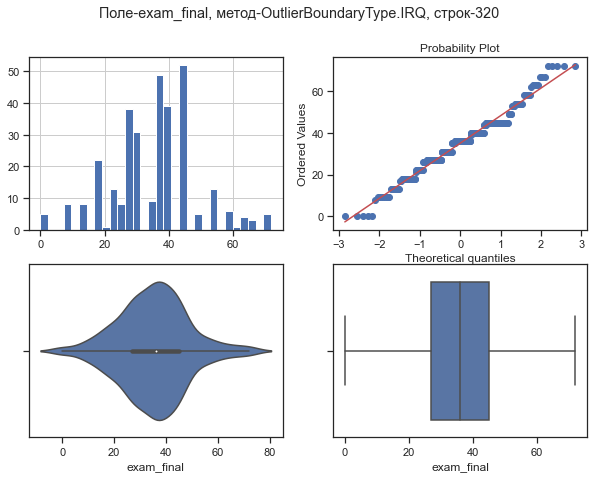

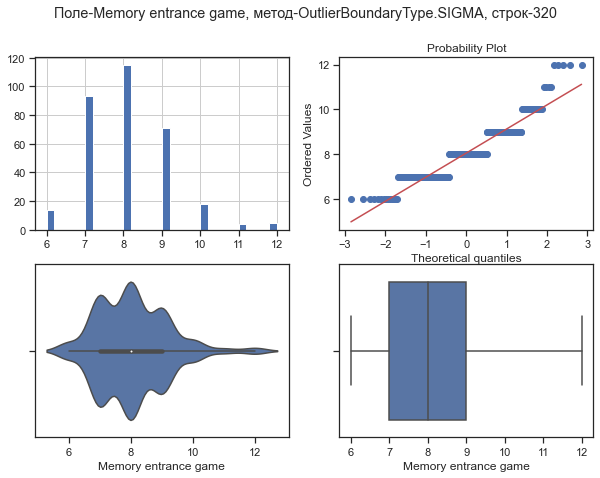

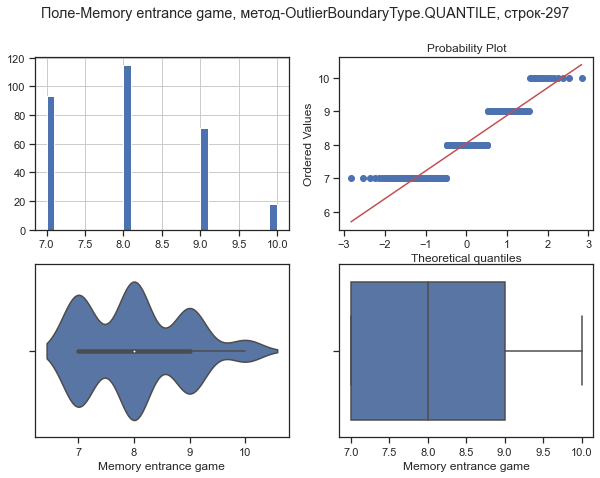

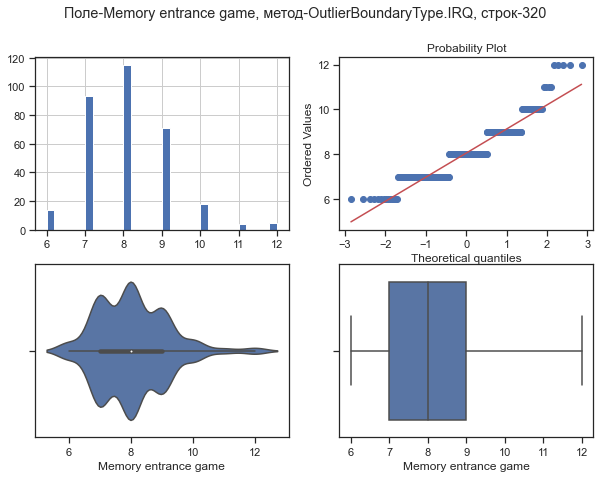

In [88]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data_to_scale[col] > upper_boundary, True, 
                                 np.where(data_to_scale[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data_to_scale.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

### Замена выбросов 

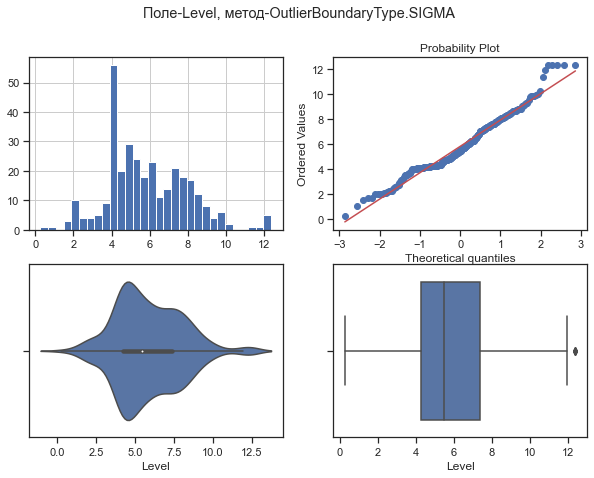

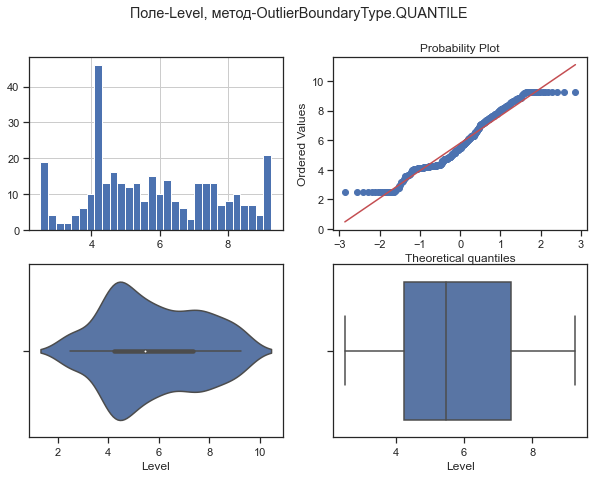

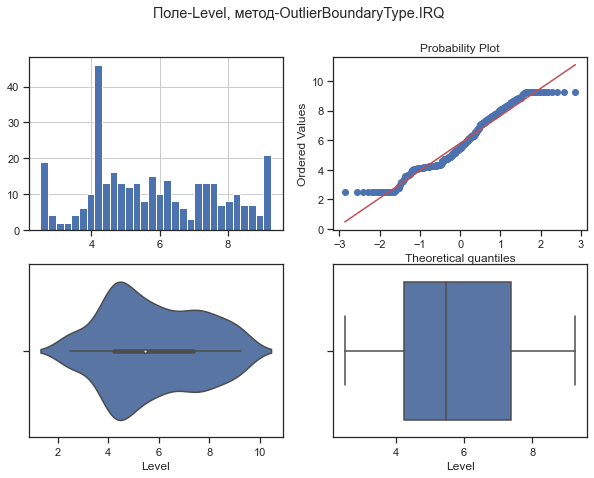

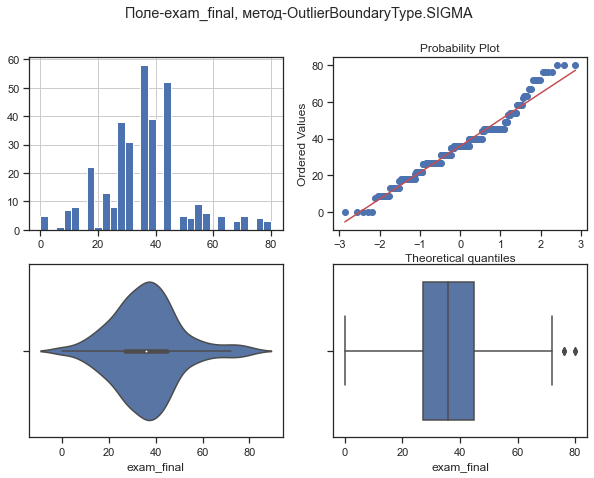

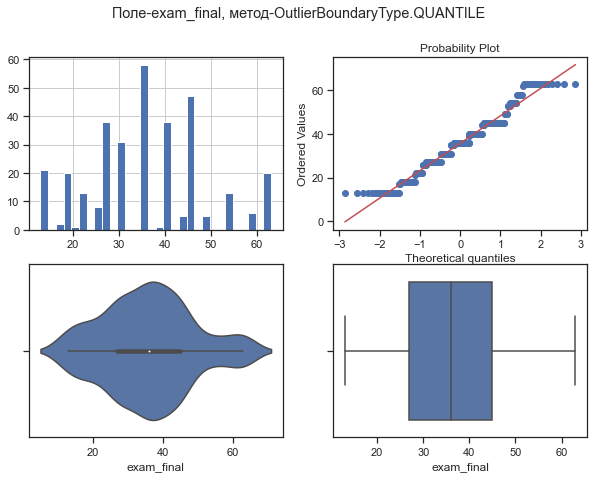

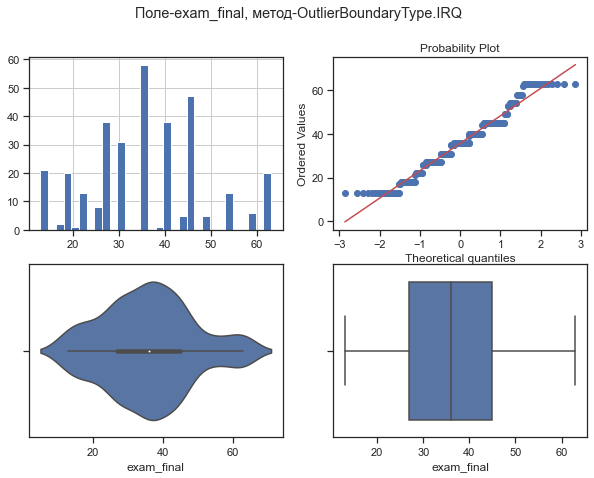

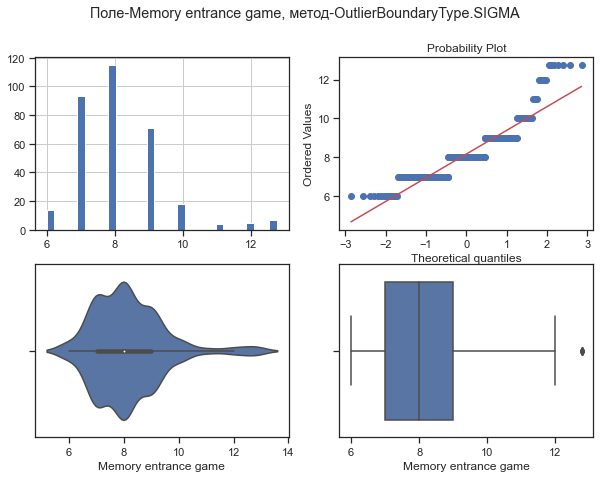

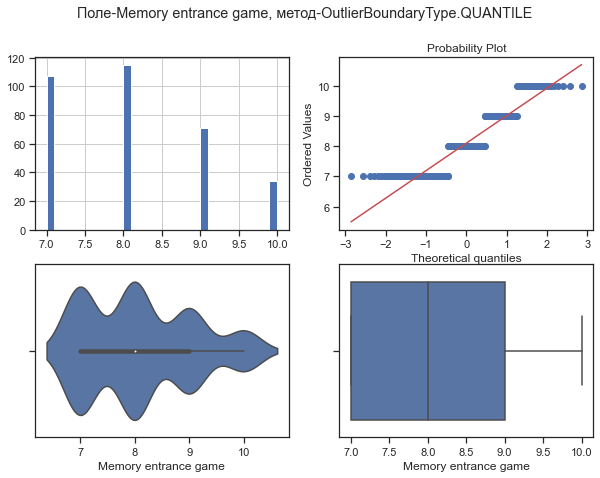

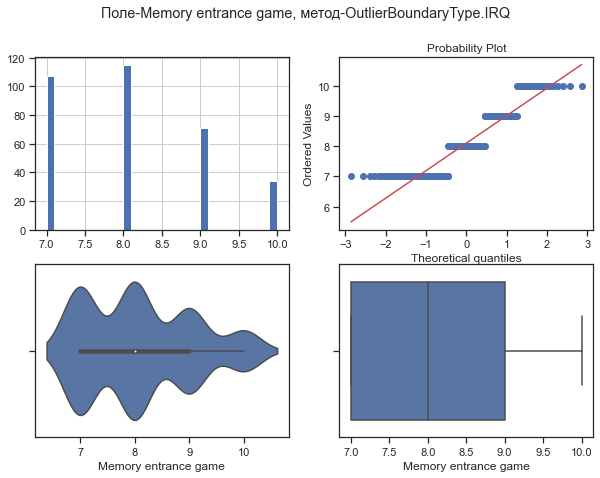

In [89]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Изменение данных
        data_to_scale[col] = np.where(data_to_scale[col] > upper_boundary, upper_boundary, 
                                 np.where(data_to_scale[col] < lower_boundary, lower_boundary, data_to_scale[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data_to_scale, col, title)

Типы признаков:
1. Бинарный - Gender
2. Вещественный
3. Категориальный
4. Порядковый
5. Set-valued --> (Heard about school form?) - признак являющийся подмножеством какого-либо множества (например, список просмотренных пользователем фильмов - подмножество всех фильмов). В данном случае - признак 'Откуда узнал о Школе21' - подмножество всех возможных способов рекламы

# Отбор признаков

## Метод фильтрации 

### Метод, основынный на корреляции 

In [102]:
cols_to_fs = ['Gender', 'Wave id', 'Level', 'day_00', 'day_02',
       'day_03', 'day_04', 'day_05', 'day_06', 'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13', 
        'evalexpr', 'bsq', 'rush_00', 'rush_01', 'exam_00', 'exam_01', 'exam_02', 'exam_final',
        'Memory entrance game', 'Logic entrance game', 'contract_status']
fs_data = data_loaded[cols_to_fs].copy()
fs_data.shape

(1060, 27)

In [103]:
fs_data_features = list(zip(
[i for i in fs_data.columns],
zip(
    #типы колонок
    [str(i) for i in fs_data.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in fs_data.isnull().sum()]
)))
fs_data_features

[('Gender', ('object', 0)),
 ('Wave id', ('int64', 0)),
 ('Level', ('float64', 0)),
 ('day_00', ('int64', 0)),
 ('day_02', ('float64', 16)),
 ('day_03', ('float64', 15)),
 ('day_04', ('float64', 23)),
 ('day_05', ('float64', 4)),
 ('day_06', ('float64', 12)),
 ('day_07', ('float64', 14)),
 ('day_08', ('float64', 15)),
 ('day_09', ('float64', 13)),
 ('day_10', ('float64', 32)),
 ('day_11', ('float64', 13)),
 ('day_12', ('float64', 10)),
 ('day_13', ('float64', 31)),
 ('evalexpr', ('float64', 57)),
 ('bsq', ('float64', 33)),
 ('rush_00', ('float64', 64)),
 ('rush_01', ('float64', 116)),
 ('exam_00', ('float64', 13)),
 ('exam_01', ('float64', 19)),
 ('exam_02', ('float64', 13)),
 ('exam_final', ('float64', 4)),
 ('Memory entrance game', ('int64', 0)),
 ('Logic entrance game', ('int64', 0)),
 ('contract_status', ('int64', 0))]

In [104]:
fs_data.tail()

,Gender,Wave id,Level,day_00,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status
1055,male,3,4.149733,10,0.0,10.0,20.0,10.0,70.0,-42.0,...,0.0,NaN,0.0,0.0,0.0,22.0,18.0,7,11,1
1056,male,3,4.320856,5,10.0,0.0,70.0,1.0,0.0,25.0,...,NaN,120.0,0.0,20.0,22.0,32.0,27.0,11,12,1
1057,male,2,6.675000,30,10.0,65.0,70.0,10.0,0.0,0.0,...,0.0,0.0,96.0,100.0,48.0,80.0,45.0,8,16,1
1058,male,3,6.483333,50,80.0,30.0,47.0,15.0,20.0,40.0,...,0.0,105.0,0.0,0.0,64.0,64.0,45.0,8,12,1
1059,male,1,4.000000,5,80.0,80.0,0.0,10.0,70.0,0.0,...,0.0,0.0,0.0,0.0,80.0,80.0,44.0,18,12,0


In [105]:
fs_data = fs_data.dropna()
fs_data.shape

(693, 27)

In [106]:
g_cat_enc_le = le.fit_transform(fs_data['Gender'])
g_cat_enc_le

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [107]:
fs_data['Gender'] = g_cat_enc_le
fs_data['Gender']

0       1
1       0
3       0
5       1
8       1
       ..
1051    0
1053    1
1057    1
1058    1
1059    1
Name: Gender, Length: 693, dtype: int32

In [108]:
fs_data

,Gender,Wave id,Level,day_00,day_02,day_03,day_04,day_05,day_06,day_07,...,bsq,rush_00,rush_01,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game,contract_status
0,1,3,7.463235,5,0.0,80.0,0.0,1.0,0.0,15.0,...,0.0,0.0,0.0,75.0,43.0,100.0,44.0,9,11,1
1,0,1,8.785714,0,10.0,45.0,5.0,1.0,35.0,0.0,...,0.0,110.0,0.0,0.0,16.0,22.0,22.0,7,10,1
3,0,1,8.146104,5,35.0,25.0,20.0,2.0,70.0,0.0,...,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6,1
5,1,1,5.264151,50,35.0,50.0,0.0,1.0,70.0,40.0,...,0.0,10.0,0.0,80.0,54.0,70.0,45.0,8,13,0
8,1,1,5.509434,5,0.0,100.0,85.0,35.0,0.0,60.0,...,0.0,0.0,0.0,80.0,38.0,80.0,44.0,7,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,0,1,7.025735,5,35.0,65.0,30.0,48.0,70.0,0.0,...,0.0,10.0,0.0,0.0,48.0,48.0,36.0,9,12,1
1053,1,1,8.652597,100,0.0,10.0,85.0,48.0,100.0,20.0,...,0.0,120.0,0.0,80.0,33.0,48.0,31.0,17,20,1
1057,1,2,6.675000,30,10.0,65.0,70.0,10.0,0.0,0.0,...,0.0,0.0,96.0,100.0,48.0,80.0,45.0,8,16,1
1058,1,3,6.483333,50,80.0,30.0,47.0,15.0,20.0,40.0,...,0.0,105.0,0.0,0.0,64.0,64.0,45.0,8,12,1


<AxesSubplot:>

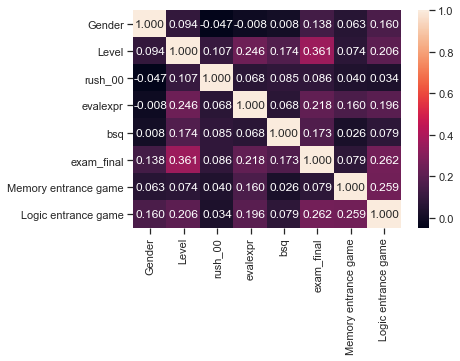

In [109]:
heatmap_cols = ['Gender', 'Level', 'rush_00', 'evalexpr', 'bsq', 'exam_final',
        'Memory entrance game', 'Logic entrance game']
sns.heatmap(fs_data[heatmap_cols].corr(), annot=True, fmt='.3f')

In [110]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr() # !!!вот здесь был недочет - data.corr -> df.corr
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.3]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [111]:
make_corr_df(fs_data)

,f1,f2,corr
0,exam_02,exam_final,0.630030
1,exam_final,exam_02,0.630030
2,exam_02,exam_01,0.618618
3,exam_01,exam_02,0.618618
4,exam_final,exam_01,0.597740
5,exam_01,exam_final,0.597740
6,Wave id,Level,0.549528
7,Level,Wave id,0.549528
8,exam_00,exam_01,0.499900
9,exam_01,exam_00,0.499900


In [112]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [113]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(fs_data))

[['exam_final', 'exam_01', 'exam_00', 'day_03', 'day_13', 'Level', 'exam_02'],
 ['Level', 'day_00', 'Wave id'],
 ['day_03', 'day_02'],
 ['day_13', 'exam_final', 'day_05', 'day_11'],
 ['day_03', 'day_08'],
 ['Level', 'contract_status']]

### Метод, основанный на статистических характеристиках 

In [118]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [119]:
x = fs_data.drop('contract_status', axis=1)
x

,Gender,Wave id,Level,day_00,day_02,day_03,day_04,day_05,day_06,day_07,...,evalexpr,bsq,rush_00,rush_01,exam_00,exam_01,exam_02,exam_final,Memory entrance game,Logic entrance game
0,1,3,7.463235,5,0.0,80.0,0.0,1.0,0.0,15.0,...,81.0,0.0,0.0,0.0,75.0,43.0,100.0,44.0,9,11
1,0,1,8.785714,0,10.0,45.0,5.0,1.0,35.0,0.0,...,0.0,0.0,110.0,0.0,0.0,16.0,22.0,22.0,7,10
3,0,1,8.146104,5,35.0,25.0,20.0,2.0,70.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,9,6
5,1,1,5.264151,50,35.0,50.0,0.0,1.0,70.0,40.0,...,0.0,0.0,10.0,0.0,80.0,54.0,70.0,45.0,8,13
8,1,1,5.509434,5,0.0,100.0,85.0,35.0,0.0,60.0,...,0.0,0.0,0.0,0.0,80.0,38.0,80.0,44.0,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,0,1,7.025735,5,35.0,65.0,30.0,48.0,70.0,0.0,...,75.0,0.0,10.0,0.0,0.0,48.0,48.0,36.0,9,12
1053,1,1,8.652597,100,0.0,10.0,85.0,48.0,100.0,20.0,...,100.0,0.0,120.0,0.0,80.0,33.0,48.0,31.0,17,20
1057,1,2,6.675000,30,10.0,65.0,70.0,10.0,0.0,0.0,...,0.0,0.0,0.0,96.0,100.0,48.0,80.0,45.0,8,16
1058,1,3,6.483333,50,80.0,30.0,47.0,15.0,20.0,40.0,...,100.0,0.0,105.0,0.0,0.0,64.0,64.0,45.0,8,12


In [120]:
y = fs_data['contract_status']
y

0       1
1       1
3       1
5       0
8       0
       ..
1051    1
1053    1
1057    1
1058    1
1059    0
Name: contract_status, Length: 693, dtype: int64

Text(0, 0.5, 'Взаимная информация')

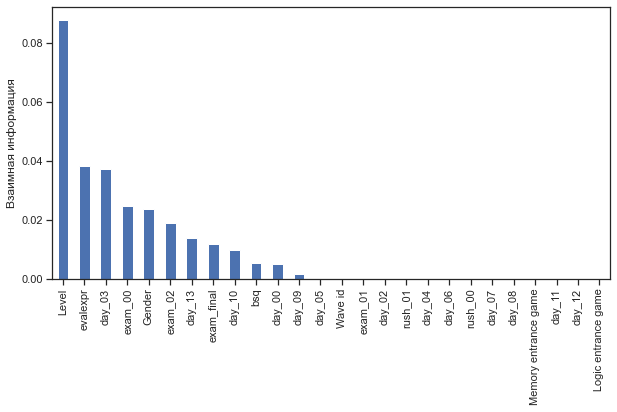

In [124]:
mi = mutual_info_regression(x, y)
mi = pd.Series(mi)
mi.index = x.columns
mi.sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.ylabel('Взаимная информация')

In [125]:
sel_mi = SelectKBest(mutual_info_regression, k=5).fit(x, y)

list(zip(x.columns, sel_mi.get_support()))

[('Gender', False),
 ('Wave id', False),
 ('Level', True),
 ('day_00', False),
 ('day_02', False),
 ('day_03', False),
 ('day_04', True),
 ('day_05', False),
 ('day_06', False),
 ('day_07', False),
 ('day_08', False),
 ('day_09', False),
 ('day_10', False),
 ('day_11', False),
 ('day_12', False),
 ('day_13', False),
 ('evalexpr', False),
 ('bsq', False),
 ('rush_00', False),
 ('rush_01', True),
 ('exam_00', False),
 ('exam_01', True),
 ('exam_02', True),
 ('exam_final', False),
 ('Memory entrance game', False),
 ('Logic entrance game', False)]

# Метод обертывания

## Алгоритм полного перебора

In [128]:
!pip install mlxtend

In [129]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

knn = KNeighborsClassifier(n_neighbors=3)

In [144]:
efs1 = EFS(knn, 
           min_features=3,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(x, y, custom_feature_names=x.columns)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 3000/17550IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Features: 8247/17550IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Features: 13423/17550IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
Notebo

Best accuracy score: 0.93
Best subset (indices): (0, 1, 2)
Best subset (corresponding names): ('Gender', 'Wave id', 'Level')


# Методы вложений

In [136]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [137]:
e_lr2 = LinearSVC(C=0.01, penalty="l1", max_iter=2000, dual=False)
e_lr2.fit(x, y)
# Коэффициенты регрессии
e_lr2.coef_

array([[ 0.00000000e+00,  1.08784460e-01,  1.67178435e-01,
        -2.85570541e-03, -2.59229584e-03, -6.98659758e-04,
        -7.99167874e-04,  0.00000000e+00, -2.50555462e-03,
        -2.90707325e-03,  1.76917428e-04,  7.18769051e-04,
         7.62326350e-04,  3.28459014e-05,  2.85715763e-03,
         4.88147487e-04, -5.08397894e-04, -3.60954616e-03,
        -1.06731983e-03, -6.67296103e-04, -7.84015980e-04,
         0.00000000e+00, -2.86318382e-03,  5.95447812e-03,
        -7.19176411e-03, -8.19466219e-03]])

In [140]:
x.columns

Index(['Gender', 'Wave id', 'Level', 'day_00', 'day_02', 'day_03', 'day_04',
       'day_05', 'day_06', 'day_07', 'day_08', 'day_09', 'day_10', 'day_11',
       'day_12', 'day_13', 'evalexpr', 'bsq', 'rush_00', 'rush_01', 'exam_00',
       'exam_01', 'exam_02', 'exam_final', 'Memory entrance game',
       'Logic entrance game'],
      dtype='object')

In [141]:
# Признак  исключен
sel_e_lr2 = SelectFromModel(e_lr2)
sel_e_lr2.fit(x, y)
sel_e_lr2.get_support()

array([False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True])

#### Линейная регуляризация 

In [142]:
# Используем L1-регуляризацию
e_ls1 = Lasso(random_state=1)
e_ls1.fit(x, y)
# Коэффициенты регрессии
list(zip(x.columns, e_ls1.coef_))

[('Gender', 0.0),
 ('Wave id', 0.0),
 ('Level', 0.0),
 ('day_00', -0.0),
 ('day_02', -0.0),
 ('day_03', -0.0),
 ('day_04', -0.0),
 ('day_05', 0.0),
 ('day_06', -2.0333482388061774e-05),
 ('day_07', -0.0),
 ('day_08', 0.0),
 ('day_09', 0.0),
 ('day_10', 0.0),
 ('day_11', 0.0),
 ('day_12', 0.0),
 ('day_13', 0.0),
 ('evalexpr', 0.0),
 ('bsq', -0.0),
 ('rush_00', -0.0),
 ('rush_01', -0.0),
 ('exam_00', -0.0),
 ('exam_01', 0.0),
 ('exam_02', 0.0),
 ('exam_final', 0.0),
 ('Memory entrance game', 0.0),
 ('Logic entrance game', 0.0)]

In [143]:
sel_e_ls1 = SelectFromModel(e_ls1)
sel_e_ls1.fit(x, y)
list(zip(x.columns, sel_e_ls1.get_support()))

[('Gender', False),
 ('Wave id', False),
 ('Level', False),
 ('day_00', False),
 ('day_02', False),
 ('day_03', False),
 ('day_04', False),
 ('day_05', False),
 ('day_06', True),
 ('day_07', False),
 ('day_08', False),
 ('day_09', False),
 ('day_10', False),
 ('day_11', False),
 ('day_12', False),
 ('day_13', False),
 ('evalexpr', False),
 ('bsq', False),
 ('rush_00', False),
 ('rush_01', False),
 ('exam_00', False),
 ('exam_01', False),
 ('exam_02', False),
 ('exam_final', False),
 ('Memory entrance game', False),
 ('Logic entrance game', False)]